# Why Momentum Really Works — Deep Internalization Notebook

Based on Gabriel Goh's Distill article: *Why Momentum Really Works* (Distill, 2017): https://distill.pub/2017/momentum/

**Design constraint:** This notebook mirrors the article's section headings.  
Everything extra (derivations, prerequisites, experiments, self-tests) lives under numbered `Add-on` sub-headings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline


In [2]:
# Helper functions used throughout the notebook

def make_spd_quadratic(eigs, theta=0.0):
    # Build a 2D symmetric positive definite matrix A with eigenvalues `eigs`,
    # rotated by angle `theta`.
    eigs = np.asarray(eigs, dtype=float)
    assert eigs.shape == (2,)
    c, s = np.cos(theta), np.sin(theta)
    Q = np.array([[c, -s],
                  [s,  c]])
    A = Q @ np.diag(eigs) @ Q.T
    return A, Q

def quad_optimum(A, b):
    # w* = A^{-1} b for f(w)=0.5 w^T A w - b^T w
    return np.linalg.solve(A, b)

def quad_loss(w, A, b):
    # f(w)=0.5 w^T A w - b^T w
    return 0.5 * (w @ (A @ w)) - (b @ w)

def run_gd(A, b, w0, alpha, steps):
    # Gradient descent: w_{k+1} = w_k - alpha (A w_k - b)
    w = np.array(w0, dtype=float)
    traj = [w.copy()]
    for _ in range(steps):
        grad = A @ w - b
        w = w - alpha * grad
        traj.append(w.copy())
    return np.asarray(traj)

def run_momentum(A, b, w0, alpha, beta, steps):
    # Heavy-ball / classical momentum:
    #   z_{k+1} = beta z_k + grad(w_k)
    #   w_{k+1} = w_k - alpha z_{k+1}
    w = np.array(w0, dtype=float)
    z = np.zeros_like(w)
    traj = [w.copy()]
    for _ in range(steps):
        grad = A @ w - b
        z = beta * z + grad
        w = w - alpha * z
        traj.append(w.copy())
    return np.asarray(traj)

def spectral_radius_2x2(M):
    # max |eig(M)| for a 2x2 matrix
    vals = np.linalg.eigvals(M)
    return float(np.max(np.abs(vals)))


# 0. Introduction

This notebook follows the article's structure closely so we can follow-along. The article's opening introduces:

- The usual "heavy ball" story and why it's incomplete
- The convex quadratic model as a microscope
- "Weak curvature conditions" and "pathological curvature"
- The momentum tweak: a short-term memory for gradients

Everything below in numbered `Add-on` blocks is *extra* derivation + intuition + experiments.

## 0.1 Add-on: Workflow that actually forces learning

Suggested loop per section:

1. **Write the claim** (1–2 sentences) in your own words.
2. **Re-derive** the math without looking (even if it's ugly).
3. **Predict** what a plot should look like *before* you plot.
4. **Run the experiment.** If your prediction was wrong, fix your model.
5. **Compress** into 3 bullets: *what matters, what doesn't, what knobs do*.

Keep a running "mistakes I made" list. Momentum will exploit your mistakes mercilessly.

## 0.2 Add-on: Notation glossary (use consistently)

We'll reuse the article's letters:

- Objective: $f(w)$
- Iterate ("position"): $w_k$
- Momentum buffer ("velocity-ish"): $z_k$
- Step-size: $\alpha > 0$
- Momentum coefficient: $\beta \in [0,1)$

Quadratic microscope:

$$
f(w)=\tfrac{1}{2} w^\top A w - b^\top w,\quad A \succ 0
$$

- Optimum: $w^\star = A^{-1} b$
- Error: $e_k := w_k - w^\star$

Eigen-decomposition (symmetric $A$):

$$
A = Q \Lambda Q^\top,\quad \Lambda=\mathrm{diag}(\lambda_1,\dots,\lambda_n),\; 0<\lambda_1\le \dots \le \lambda_n
$$

- Condition number: $\kappa := \lambda_n/\lambda_1$

## 0.3 Add-on: Prerequisites the article assumes

### 0.3.1 Eigendecomposition refresher (symmetric case)

If $A$ is symmetric:

- It has **real** eigenvalues $\lambda_i$.
- It has an **orthonormal** eigenbasis $Q=[q_1,\dots,q_n]$ with $Q^\top Q=I$.
- It diagonalizes: $A = Q\Lambda Q^\top$.

Why we care: in the $Q$-basis, quadratics **decouple** into independent 1D problems.

### 0.3.2 Convexity / curvature vocabulary

For twice-differentiable $f$:

- **$L$-smooth**: $\|\nabla f(x)-\nabla f(y)\|\le L\|x-y\|$ (gradient doesn't change too violently)
- **$\mu$-strongly convex**: $f(y)\ge f(x)+\nabla f(x)^\top (y-x)+\tfrac{\mu}{2}\|y-x\|^2$ (bowl has minimum curvature)

For a quadratic $f(w)=\tfrac{1}{2} w^\top A w$:

- $L = \lambda_{\max}(A)$, $\mu = \lambda_{\min}(A)$
- $\kappa = L/\mu$

#### Deriving the bounds from first principles: Why $L$ is an upper bound and $\mu$ is a lower bound

Let's build up the intuition step by step, starting from the simplest case.

**Step 1: What does "curvature" even mean?**

In one dimension, for a function $f(x)$, the second derivative $f''(x)$ tells you how fast the slope is changing at point $x$.

- If $f''(x) > 0$: the slope is increasing (function curves upward, like a bowl)
- If $f''(x) < 0$: the slope is decreasing (function curves downward, like a hill)
- If $f''(x) = 0$: the slope is constant (function is locally linear)

The second derivative IS the curvature.

**Step 2: What happens when curvature is constant?**

Suppose $f''(x) = c$ for all $x$ (constant curvature). What does $f$ look like?

Start at some point $a$. We know the value $f(a)$ and the slope $f'(a)$.

Since $f'' = c$ everywhere, we can integrate to find the slope at any other point:
$$
f'(x) = f'(a) + \int_a^x f''(t)\, dt = f'(a) + c(x - a)
$$

Now integrate again to find the function value:
$$
f(x) = f(a) + \int_a^x f'(t)\, dt = f(a) + \int_a^x \left[f'(a) + c(t-a)\right] dt
$$

$$
f(x) = f(a) + f'(a)(x-a) + \frac{c}{2}(x-a)^2
$$

**This is a parabola!** Constant curvature $c$ means the function is exactly a parabola with that curvature.

**Step 3: What if curvature is bounded above by $L$?**

Now suppose we don't know the exact curvature, but we know it never exceeds some value $L$:
$$
f''(x) \le L \quad \text{for all } x
$$

Start at point $a$ with value $f(a)$ and slope $f'(a)$.

Consider two functions:
- Our actual function $f(x)$ with curvature $f''(x) \le L$
- A reference parabola $p(x) = f(a) + f'(a)(x-a) + \frac{L}{2}(x-a)^2$ with constant curvature exactly $L$

Both start at the same point: $f(a) = p(a)$

Both have the same initial slope: $f'(a) = p'(a)$

But $f$ curves up slower (or equal) because $f'' \le L = p''$.

**What happens as we move away from $a$?**

At $x = a$, they're equal. As $x$ increases slightly:
- The slope of $p$ increases at rate $L$ (because $p'' = L$)
- The slope of $f$ increases at rate $\le L$ (because $f'' \le L$)

So $f'(x) \le p'(x)$ for $x > a$. The slope of $f$ falls behind.

Since $f$ has a smaller (or equal) slope, and they started at the same point, $f$ must end up at or below $p$:
$$
f(x) \le p(x) = f(a) + f'(a)(x-a) + \frac{L}{2}(x-a)^2
$$

The same logic works for $x < a$ (by symmetry of the parabola and the bound).

**This is the $L$-smoothness upper bound:** The function always lies below a parabola of curvature $L$ centered at any point.

**Step 4: What if curvature is bounded below by $\mu$?**

Now suppose curvature never goes below some positive value $\mu$:
$$
f''(x) \ge \mu > 0 \quad \text{for all } x
$$

The logic is exactly reversed.

Consider:
- Our actual function $f(x)$ with curvature $f''(x) \ge \mu$
- A reference parabola $q(x) = f(a) + f'(a)(x-a) + \frac{\mu}{2}(x-a)^2$ with constant curvature exactly $\mu$

Both start at the same point with the same slope.

But $f$ curves up faster (or equal) because $f'' \ge \mu = q''$.

As we move away from $a$:
- The slope of $f$ increases at rate $\ge \mu$
- The slope of $q$ increases at rate exactly $\mu$

So $f'(x) \ge q'(x)$, and therefore $f$ ends up at or above $q$:
$$
f(x) \ge q(x) = f(a) + f'(a)(x-a) + \frac{\mu}{2}(x-a)^2
$$

**This is the $\mu$-strong convexity lower bound:** The function always lies above a parabola of curvature $\mu$ centered at any point.

**Step 5: Extending to multiple dimensions**

In higher dimensions, the "curvature" becomes the Hessian matrix $\nabla^2 f(x)$, and "curvature in direction $v$" is $v^\top \nabla^2 f(x) v$.

- $L$-smooth means: the Hessian eigenvalues are all $\le L$
- $\mu$-strongly convex means: the Hessian eigenvalues are all $\ge \mu$

The 1D argument applies along any direction, giving the same parabolic bounds.

**Step 6: The gradient condition for $L$-smoothness**

You might wonder: where does $\|\nabla f(x) - \nabla f(y)\| \le L\|x - y\|$ come from?

This is actually equivalent to "Hessian eigenvalues $\le L$" for smooth functions. Here's why:

The gradient changes as you move. How fast can it change? By the mean value theorem:
$$
\nabla f(y) - \nabla f(x) = \left(\int_0^1 \nabla^2 f(x + t(y-x))\, dt\right) (y - x)
$$

If all Hessian eigenvalues are bounded by $L$, then:
$$
\|\nabla f(y) - \nabla f(x)\| \le L \|y - x\|
$$

So "gradient is $L$-Lipschitz" is just another way of saying "curvature is bounded by $L$."

**Summary: The sandwich**

For any point $x$ and any direction you move:

$$
\underbrace{f(x) + \nabla f(x)^\top(y-x) + \frac{\mu}{2}\|y-x\|^2}_{\text{parabola with curvature } \mu}
\;\le\; f(y) \;\le\;
\underbrace{f(x) + \nabla f(x)^\top(y-x) + \frac{L}{2}\|y-x\|^2}_{\text{parabola with curvature } L}
$$

The function is sandwiched between two parabolas at every point.

**Why this matters for optimization:**

| Property | What it controls | Optimization consequence |
|----------|------------------|-------------------------|
| $L$ (smoothness) | Max curvature | Limits how large a step you can safely take: $\alpha < 2/L$ |
| $\mu$ (strong convexity) | Min curvature | Guarantees the function doesn't flatten out; ensures progress toward optimum |
| $\kappa = L/\mu$ | Ratio of max to min curvature | Measures how "stretched" the level sets are; higher $\kappa$ = slower convergence |

**For quadratics, the bounds are tight:**

When $f(w) = \frac{1}{2}w^\top A w$, the Hessian is constant: $\nabla^2 f = A$ everywhere. The eigenvalues of $A$ are exactly the curvatures in the eigendirections:
- $L = \lambda_{\max}$ = steepest curvature direction (the function curves up fastest here)
- $\mu = \lambda_{\min}$ = gentlest curvature direction (the function curves up slowest here)

So quadratics are the "boundary case" where both parabolic bounds are achieved with equality as the function IS a paraboloid, and its curvature varies from $\mu$ to $L$ depending on direction.

### 0.3.3 Geometric convergence / "linear rate"

If an error evolves as $ \|e_k\|\le \rho^k \|e_0\|$ with $0<\rho<1$, then:

- "Exponential/linear convergence" = error shrinks by a constant factor per iteration.
- Iterations to reach $\varepsilon$: $k \gtrsim \log(\varepsilon)/\log(\rho)$.

In [3]:
# Quick eigendecomposition sanity check (symmetric 2x2)

A = np.array([[4., 2.],
              [2., 1.]])

evals, Q = np.linalg.eigh(A)   # for symmetric matrices
Lambda = np.diag(evals)

print("Eigenvalues:", evals)
print("Q (columns are eigenvectors):", Q)
print("Reconstruction Q Λ Q^T:", Q @ Lambda @ Q.T)
print("Reconstruction error:", np.linalg.norm(A - Q @ Lambda @ Q.T))


Eigenvalues: [0. 5.]
Q (columns are eigenvectors): [[ 0.4472 -0.8944]
 [-0.8944 -0.4472]]
Reconstruction Q Λ Q^T: [[4. 2.]
 [2. 1.]]
Reconstruction error: 0.0


## 0.4 Add-on: "Weak curvature conditions" (what does that phrase hide?)

In the article's opening, "under a few weak curvature conditions" is shorthand for:  
there exist assumptions on $f$ that are weaker than "quadratic everywhere" but still strong enough to guarantee a **linear rate**.

Two common routes:

1) **$\mu$-strong convex + $L$-smooth** (classic convex setting)  
   Gradient descent with a suitable $\alpha$ satisfies  
   $$
   f(w_k)-f(w^\star)\le \rho^k\,(f(w_0)-f(w^\star)),\quad \rho \approx 1-\mu/L = 1-1/\kappa.
   $$
   This is already "exponential," but painfully slow when $\kappa$ is large.

2) **Polyak–Łojasiewicz (PL) inequality** (often called "weakly strongly convex")  
   $$
   \tfrac{1}{2}\|\nabla f(w)\|^2 \ge \mu\,(f(w)-f^\star).
   $$
   PL implies a linear rate for gradient descent even when $f$ is not convex.
   (Many overparameterized least-squares-like problems satisfy PL locally or globally.)

For this notebook we mostly live in the quadratic world, because it lets us solve the dynamics exactly.

## 0.5 Add-on: Why quadratics are the right microscope

For a twice-differentiable $f$, near a point $w_0$,

$$
f(w)\approx f(w_0) + \nabla f(w_0)^\top (w-w_0) + \tfrac{1}{2} (w-w_0)^\top H(w_0) (w-w_0)
$$

where $H(w_0)=\nabla^2 f(w_0)$.

So locally, optimization "feels like" a quadratic with $A \approx H(w_0)$.  
This is why eigenvalues/eigenvectors of curvature keep showing up in real training curves.

Caveat: in nonconvex deep nets, $H$ changes with $w$, and can be indefinite.  
But locally, for small steps, the same linear-systems intuition often predicts behavior (oscillations, stiffness, etc.).

## 0.6 Add-on: Momentum variants

This article analyzes **classical momentum / Polyak heavy-ball**:

$$
z_{k+1}=\beta z_k+\nabla f(w_k),\qquad
w_{k+1}=w_k-\alpha z_{k+1}.
$$

**Nesterov accelerated gradient (NAG)** uses a *lookahead* gradient (roughly):  
$\nabla f(w_k - \alpha\beta z_k)$ instead of $\nabla f(w_k)$.

Both can "accelerate," but their stability and guarantees differ.  
In this notebook, "momentum" = heavy-ball unless explicitly stated otherwise.

# 1. First Steps: Gradient Descent

The article's move: analyze gradient descent on a convex quadratic because it is solvable *exactly*, and still captures "stiffness" / pathological curvature.

## 1.1 Add-on: Quadratic model + gradient descent update

Take the quadratic:

$$
f(w)=\tfrac{1}{2} w^\top A w - b^\top w,\quad A\succ 0.
$$

Gradient:

$$
\nabla f(w) = A w - b.
$$

Setting $\nabla f(w^\star)=0$ gives the optimum:

$$
A w^\star - b = 0 \Rightarrow w^\star = A^{-1} b.
$$

Gradient descent (GD):

$$
w_{k+1}=w_k-\alpha \nabla f(w_k)=w_k-\alpha(Aw_k-b).
$$

Define the error $e_k:=w_k-w^\star$. Using $Aw^\star=b$,

$$
\begin{aligned}
e_{k+1}
&= w_{k+1}-w^\star \\
&= \big(w_k-\alpha(Aw_k-b)\big)-w^\star \\
&= (w_k-w^\star)-\alpha A(w_k-w^\star) \\
&= (I-\alpha A)e_k.
\end{aligned}
$$

So GD on a quadratic is a **linear dynamical system**.

## 1.2 Add-on: The eigenspace trick (why it decouples into 1D problems)

Because $A$ is symmetric:

$$
A = Q\Lambda Q^\top,\quad Q^\top Q = I.
$$

Change coordinates to the eigenbasis:

$$
x_k := Q^\top e_k = Q^\top (w_k-w^\star).
$$

Then

$$
x_{k+1} = Q^\top e_{k+1} = Q^\top (I-\alpha A)e_k
        = (I-\alpha \Lambda)\,Q^\top e_k
        = (I-\alpha \Lambda)x_k.
$$

Since $\Lambda$ is diagonal, this is $n$ independent scalar recurrences:

$$
x^{(i)}_{k+1} = (1-\alpha \lambda_i)\,x^{(i)}_k.
$$

**Interpretation:** each eigen-direction is its own little 1D optimization problem.

## 1.3 Add-on: Stability = spectral radius (why $|1-\alpha\lambda|<1$ is everything)

In 1D, $x_{k+1}=r x_k$ converges to 0 iff $|r|<1$.

For GD modes, $r_i = 1-\alpha\lambda_i$.  
So convergence for *all* modes is:

$$
|1-\alpha \lambda_i|<1 \quad \forall i
\;\;\Longleftrightarrow\;\;
0<\alpha\lambda_i<2 \quad \forall i
\;\;\Longleftrightarrow\;\;
0<\alpha<\tfrac{2}{\lambda_n}.
$$

In matrix terms, GD is stable iff the **spectral radius**  
$\rho(I-\alpha A) = \max_i |1-\alpha\lambda_i|$ is < 1.

## 1.4 Add-on: "Pathological curvature" = an ellipsoid with a huge aspect ratio

For the centered quadratic $f(w)-f(w^\star)=\tfrac{1}{2} e^\top A e$, level sets are ellipsoids:

$$
\{e:\; e^\top A e = \text{const}\}.
$$

- If $\kappa=\lambda_n/\lambda_1 \approx 1$, the ellipsoid is close to a sphere → easy optimization.
- If $\kappa \gg 1$, the ellipsoid is extremely stretched ("ravine/valley") → GD must pick $\alpha$ small enough for the steep direction, and then crawls along the flat direction.

So "pathological curvature" ≈ "bad conditioning."

## 1.5 Prediction (GD trajectory experiment)

**Before running the cells below, write your predictions:**

1. In original coordinates, will the trajectory go straight to $w^*$ or zig-zag?
2. In eigenspace coordinates, which axis (mode) should converge faster — the one with $\lambda_1=0.2$ or $\lambda_2=2.0$?
3. Given $\alpha=0.5$, what are the per-mode contraction factors $|1-\alpha\lambda_i|$? Are both stable?

---

**After running, check:**
- Did the trajectory behave as predicted?
- If not, what was wrong in your mental model?

In [4]:
# Experiment: GD trajectory in original coordinates vs eigenspace

# Build a rotated quadratic with eigenvalues (lambda1, lambda2)
lambda1, lambda2 = 0.2, 2.0  # condition number = 10
A, Q = make_spd_quadratic([lambda1, lambda2], theta=np.pi/6)

b = np.array([1.0, 1.0])
w_star = quad_optimum(A, b)

w0 = np.array([0.0, 0.0])
alpha = 0.5
steps = 40

traj_w = run_gd(A, b, w0, alpha, steps)
traj_x = (traj_w - w_star) @ Q  # eigenspace coordinates of error (since Q orthonormal)

print(f"Condition number κ = {lambda2/lambda1:.1f}")
print("Eigenvalues:", [lambda1, lambda2])
print("alpha:", alpha)


Condition number κ = 10.0
Eigenvalues: [0.2, 2.0]
alpha: 0.5


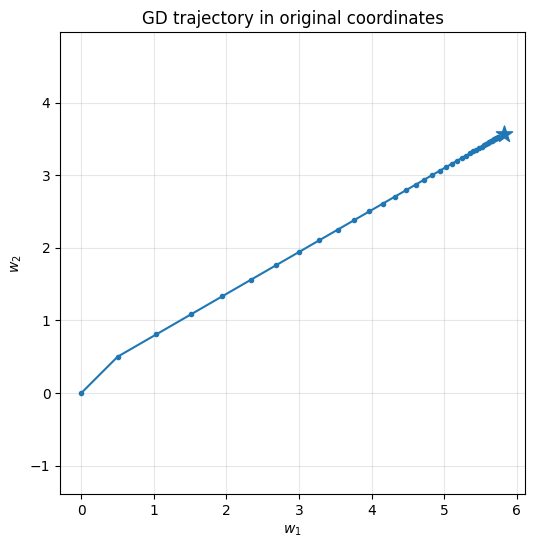

In [5]:
# Plot: original space

plt.figure(figsize=(6, 6))
plt.plot(traj_w[:, 0], traj_w[:, 1], marker='o', markersize=3)
plt.scatter([w_star[0]], [w_star[1]], marker='*', s=150)
plt.title("GD trajectory in original coordinates")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.grid(alpha=0.3)
plt.axis("equal")
plt.show()


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/4k/95314zmn21d5xcrshp9h538m0000gn/T/ipykernel_76686/3605748206.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$x_1$ (mode with $\lambda_1$)")
/var/folders/4k/95314zmn21d5xcrshp9h538m0000gn/T/ipykernel_76686/3605748206.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$x_2$ (mode with $\lambda_2$)")


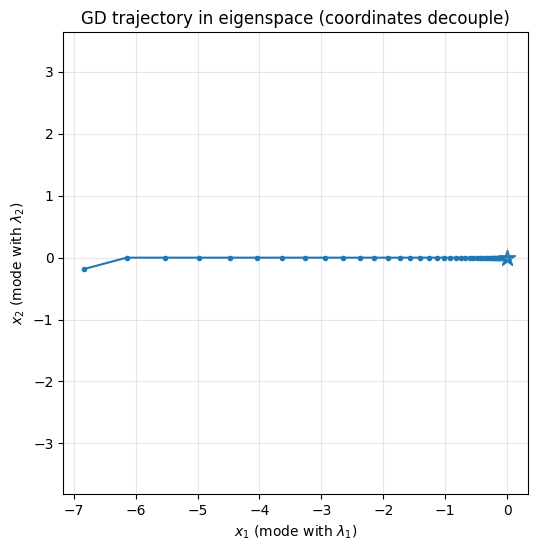

In [6]:
# Plot: eigenspace (decoupled axes)

plt.figure(figsize=(6, 6))
plt.plot(traj_x[:, 0], traj_x[:, 1], marker='o', markersize=3)
plt.scatter([0.0], [0.0], marker='*', s=150)
plt.title("GD trajectory in eigenspace (coordinates decouple)")
plt.xlabel("$x_1$ (mode with $\lambda_1$)")
plt.ylabel("$x_2$ (mode with $\lambda_2$)")
plt.grid(alpha=0.3)
plt.axis("equal")
plt.show()


## 1.6 Quick self-test (First Steps: Gradient Descent)

*Without scrolling up:*

1. For GD on a quadratic $f(w) = \frac{1}{2}w^\top A w - b^\top w$, derive the error dynamics $e_{k+1} = (?)e_k$.
2. Why does the problem "decouple" in the eigenbasis of $A$?
3. What is the per-mode contraction factor for eigenvalue $\lambda_i$?
4. For stability, what constraint must $\alpha$ satisfy in terms of $\lambda_{\max}$?

<details>
<summary>Answers</summary>

1. $e_{k+1} = (I - \alpha A)e_k$
2. Because $A = Q\Lambda Q^\top$ with orthonormal $Q$, so in coordinates $x_k = Q^\top e_k$, we get $x_{k+1} = (I - \alpha\Lambda)x_k$ — a diagonal system.
3. $|1 - \alpha\lambda_i|$
4. $0 < \alpha < 2/\lambda_{\max}$

</details>

## 1.7 Decomposing the Error

The article's key claim: GD is fast on *high curvature* modes (large $\lambda$), slow on *low curvature* modes (small $\lambda$).  
This creates the classic "fast drop, then slog."

### 1.7.1 Add-on: Solve each eigenmode and decompose the loss (step-by-step)

From

$$
x^{(i)}_{k+1}=(1-\alpha\lambda_i)\,x^{(i)}_k
$$

we get

$$
x^{(i)}_k = (1-\alpha\lambda_i)^k\,x^{(i)}_0.
$$

For the quadratic **centered at the optimum**:

$$
f(w)-f(w^\star)=\tfrac{1}{2} (w-w^\star)^\top A (w-w^\star)
= \tfrac{1}{2} e^\top A e.
$$

In eigen-coordinates $e = Qx$, so:

$$
\begin{aligned}
f(w)-f(w^\star)
&= \tfrac{1}{2} (Qx)^\top (Q\Lambda Q^\top)(Qx) \\
&= \tfrac{1}{2} x^\top \Lambda x \\
&= \tfrac{1}{2} \sum_{i=1}^n \lambda_i \left(x^{(i)}\right)^2.
\end{aligned}
$$

Plugging $x^{(i)}_k$ in:

$$
f(w_k)-f(w^\star)
= \tfrac{1}{2} \sum_{i=1}^n \lambda_i \left(1-\alpha\lambda_i\right)^{2k}\left(x^{(i)}_0\right)^2.
$$

So each eigenmode contributes a geometric decay term with rate $|1-\alpha\lambda_i|$.

### 1.7.2 Prediction (loss decomposition experiment)

**Before running:**

1. With $\lambda \in \{0.01, 0.1, 1.0\}$ and $\alpha=0.5$, which mode will hit machine precision first?
2. What are the contraction rates $|1-\alpha\lambda|$ for each mode?
3. After $k=500$ iterations, roughly how much of the total loss will be from the slowest mode?

---

**After running, check:** Did the "fast drop, then slog" pattern appear? Which mode dominated at the end?

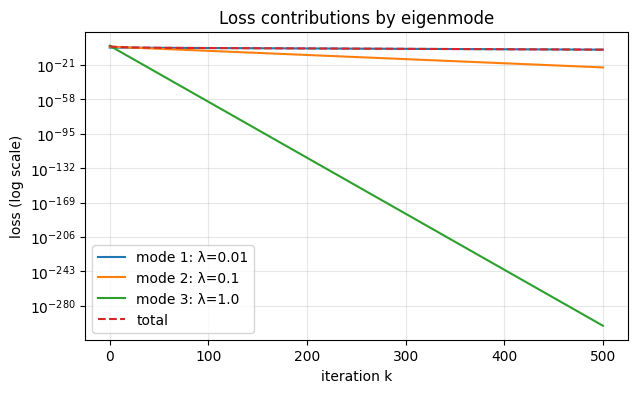

Rates |1-αλ|:
  λ=0.01: |1-0.5×0.01| = 0.99500
  λ=0.1: |1-0.5×0.1| = 0.95000
  λ=1.0: |1-0.5×1.0| = 0.50000


In [9]:
# Experiment: loss decomposition by eigenmode (synthetic 1D modes)

lambdas = np.array([0.01, 0.1, 1.0])  # three eigenvalues
alpha = 0.5
x0 = np.ones_like(lambdas)
K = 500

k = np.arange(K + 1)
mode_losses = []
for lam in lambdas:
    xk = x0[0] * (1 - alpha * lam) ** k
    mode_losses.append(0.5 * lam * xk**2)
mode_losses = np.array(mode_losses)
total = mode_losses.sum(axis=0)

plt.figure(figsize=(7, 4))
for i, lam in enumerate(lambdas):
    plt.semilogy(k, mode_losses[i], label=f"mode {i+1}: λ={lam}")
plt.semilogy(k, total, linestyle="--", label="total")
plt.title("Loss contributions by eigenmode")
plt.xlabel("iteration k")
plt.ylabel("loss (log scale)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print("Rates |1-αλ|:")
for lam in lambdas:
    print(f"  λ={lam}: |1-{alpha}×{lam}| = {abs(1-alpha*lam):.5f}")


## 1.8 Choosing A Step-size

The step-size $\alpha$ is a stability knob and a speed knob.  
On quadratics, you can reason about it exactly.

### 1.8.1 Add-on: Derive stability and the optimal fixed step-size

**Stability** for all modes requires

$$
|1-\alpha\lambda_i|<1\quad\forall i
\;\;\Longleftrightarrow\;\;
0<\alpha<\tfrac{2}{\lambda_n}.
$$

**Best fixed $\alpha$** (minimize worst-case contraction):

The overall convergence rate is determined by the slowest-shrinking mode:

$$
\rho(\alpha)=\max_i |1-\alpha\lambda_i|
           = \max\left\{|1-\alpha\lambda_1|,\;|1-\alpha\lambda_n|\right\}
$$

(The endpoints $\lambda_1$ and $\lambda_n$ give the extreme values because $|1-\alpha\lambda|$ is linear in $\lambda$.)

#### Why we equate the two endpoint terms

For the optimal step size, we're in a regime where:
- $\alpha\lambda_1 < 1$, so $|1-\alpha\lambda_1| = 1 - \alpha\lambda_1$ (positive, no absolute value needed)
- $\alpha\lambda_n > 1$, so $|1-\alpha\lambda_n| = \alpha\lambda_n - 1$ (we've "overshot" zero)

Now watch what happens as we vary $\alpha$:

| As $\alpha$ increases... | Slow mode factor $1-\alpha\lambda_1$ | Fast mode factor $\alpha\lambda_n - 1$ |
|--------------------------|--------------------------------------|----------------------------------------|
| | goes DOWN | goes UP |

One factor is **decreasing** in $\alpha$, the other is **increasing** in $\alpha$.

The overall rate $\rho(\alpha) = \max\{\text{slow}, \text{fast}\}$ is therefore:
- Dominated by the slow mode when $\alpha$ is small
- Dominated by the fast mode when $\alpha$ is large
- **Minimized exactly where they cross**

When you're minimizing the maximum of a decreasing function and an increasing function, the optimum is always at their intersection. Anywhere else, one of them is unnecessarily large.

Setting them equal:
$$
1-\alpha\lambda_1 = \alpha\lambda_n - 1
$$
$$
2 = \alpha(\lambda_1 + \lambda_n)
$$
$$
\alpha^\star = \frac{2}{\lambda_1+\lambda_n}
$$

The optimal rate is then:
$$
\rho^\star = 1 - \alpha^\star\lambda_1 = 1 - \frac{2\lambda_1}{\lambda_1+\lambda_n} = \frac{\lambda_n - \lambda_1}{\lambda_n + \lambda_1} = \frac{\kappa-1}{\kappa+1}
$$

---

#### Why $\rho^\star \to 1$ means slow convergence

After $k$ iterations, the error shrinks to $\rho^k$ times its original size. To reach a target accuracy $\varepsilon$, we need $\rho^k = \varepsilon$, so:

$$
k = \frac{\log \varepsilon}{\log \rho}
$$

When $\rho$ is close to 1, $\log\rho \approx -(1-\rho)$ (first-order Taylor expansion). So:

$$
k \approx \frac{|\log \varepsilon|}{1 - \rho}
$$

**The number of iterations is inversely proportional to $(1-\rho)$.**

Now, as $\kappa \to \infty$:
$$
\rho^\star = \frac{\kappa-1}{\kappa+1} = 1 - \frac{2}{\kappa+1} \approx 1 - \frac{2}{\kappa}
$$

So $1 - \rho^\star \approx 2/\kappa$, which means:
$$
k \approx \frac{|\log\varepsilon| \cdot \kappa}{2} = O(\kappa)
$$

**GD needs $O(\kappa)$ iterations to converge.** When $\kappa$ is large (ill-conditioned problem), this is brutal:

| $\kappa$ | $\rho^\star$ | Iterations for $10^{-6}$ accuracy |
|----------|--------------|-----------------------------------|
| 10 | 0.818 | 69 |
| 100 | 0.980 | 688 |
| 1,000 | 0.998 | 6,905 |
| 10,000 | 0.9998 | 69,077 |

The geometric intuition: a large $\kappa$ means the loss landscape is a narrow valley. To avoid overshooting across the narrow direction, $\alpha$ must be small. But then progress along the long direction is painfully slow as we're taking tiny steps in a direction that requires traveling a long distance.

**This $O(\kappa)$ scaling is the fundamental bottleneck that momentum breaks**, achieving $O(\sqrt{\kappa})$ instead.

### 1.8.2 Prediction (step-size vs convergence rate)

**Before running:**

1. The plot shows $|1-\alpha\lambda_1|$ and $|1-\alpha\lambda_n|$. At what $\alpha$ does each curve equal 1?
2. For the optimal $\alpha^* = 2/(\lambda_1+\lambda_n)$, the two curves should intersect. What's the y-value at intersection?
3. Is the optimal rate closer to 0 or to 1 when $\kappa=100$?

---

**After running, check:** Did the curves intersect where you expected? How many iterations for $10^{-6}$ reduction?

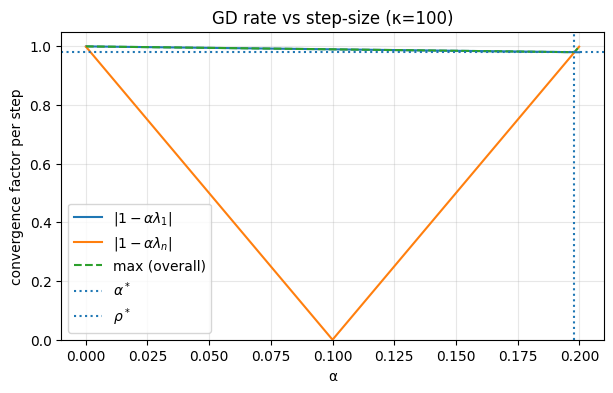

alpha* = 0.198020
rho*   = 0.980198
iters for 1e-6 reduction: 691


In [10]:
# Experiment: visualize GD convergence factor vs step-size α

lambda1, lambda_n = 0.1, 10.0
kappa = lambda_n / lambda1

alpha_vals = np.linspace(1e-4, 2/lambda_n - 1e-4, 400)
rate1 = np.abs(1 - alpha_vals * lambda1)
raten = np.abs(1 - alpha_vals * lambda_n)
overall = np.maximum(rate1, raten)

alpha_star = 2 / (lambda1 + lambda_n)
rho_star = (kappa - 1) / (kappa + 1)

plt.figure(figsize=(7, 4))
plt.plot(alpha_vals, rate1, label=r"$|1-\alpha\lambda_1|$")
plt.plot(alpha_vals, raten, label=r"$|1-\alpha\lambda_n|$")
plt.plot(alpha_vals, overall, linestyle="--", label="max (overall)")
plt.axvline(alpha_star, linestyle=":", label=r"$\alpha^*$")
plt.axhline(rho_star, linestyle=":", label=r"$\rho^*$")
plt.title(f"GD rate vs step-size (κ={kappa:.0f})")
plt.xlabel("α")
plt.ylabel("convergence factor per step")
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print(f"alpha* = {alpha_star:.6f}")
print(f"rho*   = {rho_star:.6f}")
print(f"iters for 1e-6 reduction: {np.log(1e-6)/np.log(rho_star):.0f}")


### 1.8.3 Quick self-test (Choosing A Step-size)

*Without scrolling up:*

1. Why does the optimal fixed step-size balance $|1-\alpha\lambda_1| = |1-\alpha\lambda_n|$?
2. What is $\alpha^*$ for optimal GD?
3. What is the resulting convergence rate $\rho^*$ in terms of $\kappa$?
4. As $\kappa \to \infty$, how does $\rho^*$ behave?

<details>
<summary>Answers</summary>

1. The overall rate is $\max(|1-\alpha\lambda_1|, |1-\alpha\lambda_n|)$. To minimize a max, balance the two terms.
2. $\alpha^* = 2/(\lambda_1 + \lambda_n)$
3. $\rho^* = (\kappa - 1)/(\kappa + 1)$
4. $\rho^* \approx 1 - 2/\kappa \to 1$ (slow convergence)

</details>

# 2. Example: Polynomial Regression

The article's point here: eigenvectors are not abstract as in real problems they correspond to meaningful "features," and GD learns some features much faster than others.

This example uses polynomial regression as a concrete "eigenfeatures" story.

## 2.1 Add-on: Vandermonde matrix → normal equations (show the quadratic)

Given data $(\xi_i, d_i)$ and a degree-$(n-1)$ polynomial model

$$
\text{model}(\xi)=\sum_{j=0}^{n-1} w_{j}\,\xi^{j},
$$

define the Vandermonde/design matrix $Z\in\mathbb{R}^{m\times n}$:

$$
Z_{i,j} = \xi_i^{\,j}.
$$

Then the least squares objective is

$$
\min_w \tfrac{1}{2}\|Zw-d\|^2
= \tfrac{1}{2} w^\top (Z^\top Z) w - (Z^\top d)^\top w + \text{const}.
$$

So it's exactly our quadratic microscope with:

- $A = Z^\top Z$
- $b = Z^\top d$

GD dynamics are governed by eigenvalues/eigenvectors of $Z^\top Z$.

## 2.2 Add-on: Eigenfeatures, SVD, and "sensitivity to noise"

Let $Z = U\Sigma V^\top$ be the SVD.

Then:

- $Z^\top Z = V \Sigma^2 V^\top$
- eigenvectors of $Z^\top Z$ are columns of $V$
- eigenvalues are $\sigma_i^2$

Small $\sigma_i$ (small eigenvalues) correspond to directions where:

- the data has little support / leverage
- the inverse problem is ill-conditioned
- tiny noise in $d$ causes large changes in the fitted $w$

That's why high-degree polynomial fits are famously unstable unless you regularize.

## 2.3 Prediction (polynomial regression experiments)

**Before running:**

1. The eigenvalues of $Z^\top Z$ span many orders of magnitude. Should the condition number be large or small?
2. "Eigenfeatures" corresponding to small eigenvalues are typically high-frequency or low-frequency?
3. In early stopping: at iteration 1, will the fit be underfit, overfit, or just right?
4. As iterations increase, does the fit first improve then worsen, or monotonically improve?

---

**After running, check:** Did the eigenvalue spread match your intuition? What happened to the fit at different iterations?

## 2.4 Add-on: Early stopping as a spectral filter (compare to Tikhonov)

Tikhonov (ridge) solves:

$$
\min_w \tfrac{1}{2}\|Zw-d\|^2 + \tfrac{\eta}{2}\|w\|^2
\Rightarrow
w_\eta = (Z^\top Z + \eta I)^{-1}Z^\top d.
$$

In the eigenbasis of $Z^\top Z$, each mode is shrunk by:

$$
\text{ridge filter:}\;\;\; g_\eta(\lambda)=\frac{\lambda}{\lambda+\eta}.
$$

GD starting at $w_0=0$ has closed form:

$$
w_k = \sum_{t=0}^{k-1} (I-\alpha A)^t \alpha b
$$

and in each eigenmode $\lambda$:

$$
\text{early-stop filter:}\;\;\; g_k(\lambda)=1-(1-\alpha\lambda)^k.
$$

Both suppress small-$\lambda$ directions early — that's why early stopping acts like regularization.

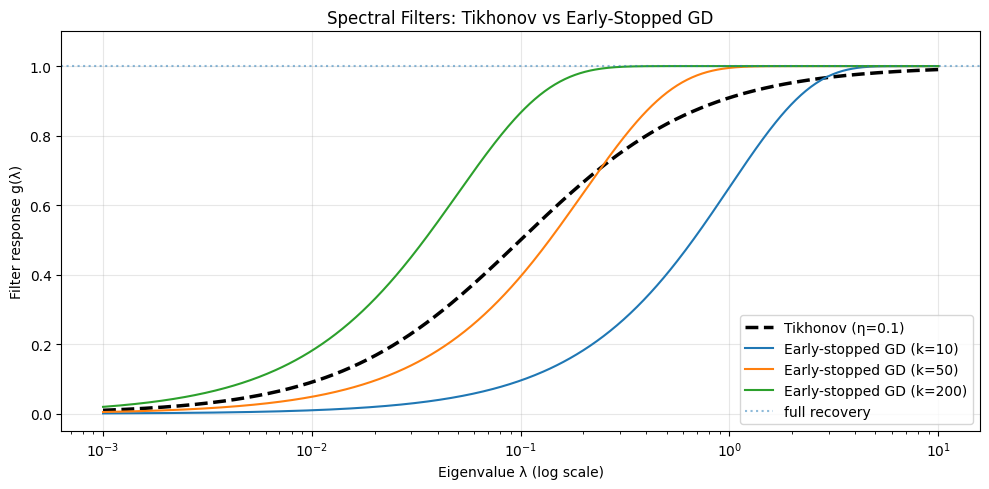

Key observations:
• Both filters suppress small-λ directions (regularization effect)
• Ridge: smooth transition, controlled by η
• Early-stopping: discrete approximation that improves with more iterations
• Large λ: both approach 1 (full learning)
• Small λ: both stay near 0 (suppressed/regularized)


In [11]:
# Experiment: compare Tikhonov (ridge) vs early-stopping spectral filters

def ridge_filter(lam, eta):
    """Ridge/Tikhonov spectral filter: g_η(λ) = λ / (λ + η)"""
    return lam / (lam + eta)

def gd_early_stop_filter(lam, alpha, k):
    """Early-stopped GD spectral filter: g_k(λ) = 1 - (1 - αλ)^k"""
    return 1 - (1 - alpha * lam) ** k

# Log-spaced eigenvalues to see behavior across scales
lambda_vals = np.logspace(-3, 1, 500)  # λ from 0.001 to 10

# Parameters
eta = 0.1      # Ridge regularization strength
alpha = 0.1   # GD step size
k_vals = [10, 50, 200]  # Different stopping times

plt.figure(figsize=(10, 5))

# Ridge filter
ridge = ridge_filter(lambda_vals, eta)
plt.semilogx(lambda_vals, ridge, 'k--', linewidth=2.5, label=f'Tikhonov (η={eta})')

# Early-stopped GD filters
colors = ['C0', 'C1', 'C2']
for k, color in zip(k_vals, colors):
    gd_filter = gd_early_stop_filter(lambda_vals, alpha, k)
    plt.semilogx(lambda_vals, gd_filter, color=color, linewidth=1.5, 
                 label=f'Early-stopped GD (k={k})')

plt.axhline(1.0, linestyle=':', alpha=0.5, label='full recovery')
plt.xlabel('Eigenvalue λ (log scale)')
plt.ylabel('Filter response g(λ)')
plt.title('Spectral Filters: Tikhonov vs Early-Stopped GD')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.ylim(-0.05, 1.1)

plt.tight_layout()
plt.show()

print("Key observations:")
print("• Both filters suppress small-λ directions (regularization effect)")
print("• Ridge: smooth transition, controlled by η")
print("• Early-stopping: discrete approximation that improves with more iterations")
print("• Large λ: both approach 1 (full learning)")
print("• Small λ: both stay near 0 (suppressed/regularized)")

In [12]:
# Experiment setup: polynomial regression and spectrum of Z^T Z

np.random.seed(0)

m = 50          # number of data points
degree = 10     # number of polynomial coefficients
xi = np.linspace(-1, 1, m)

true_f = lambda x: np.sin(2*np.pi*x)
d = true_f(xi) + 0.2*np.random.randn(m)

# Vandermonde matrix (increasing powers)
Z = np.vander(xi, degree, increasing=True)

A = Z.T @ Z
b = Z.T @ d

evals, V = np.linalg.eigh(A)  # evals sorted ascending
kappa = evals[-1] / evals[0]

print("Eigenvalues of Z^T Z (ascending):")
print(evals)
print(f"Condition number κ ≈ {kappa:.2e}")


Eigenvalues of Z^T Z (ascending):
[ 0.      0.0002  0.0043  0.0209  0.1758  0.723   3.6631 11.9725 35.1288
 63.4507]
Condition number κ ≈ 1.46e+06


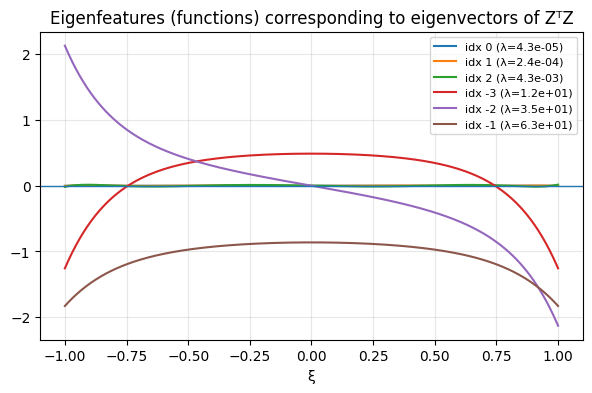

In [13]:
# Plot a few eigenfeatures (eigenvectors interpreted as polynomial coefficient vectors)

xi_plot = np.linspace(-1, 1, 400)
Z_plot = np.vander(xi_plot, degree, increasing=True)

# Choose a few indices: smallest, mid, largest
idxs = [0, 1, 2, -3, -2, -1]

plt.figure(figsize=(7, 4))
for idx in idxs:
    feature = Z_plot @ V[:, idx]
    plt.plot(xi_plot, feature, label=f"idx {idx} (λ={evals[idx]:.1e})")
plt.axhline(0, linewidth=1)
plt.title("Eigenfeatures (functions) corresponding to eigenvectors of ZᵀZ")
plt.xlabel("ξ")
plt.grid(alpha=0.3)
plt.legend(fontsize=8)
plt.show()


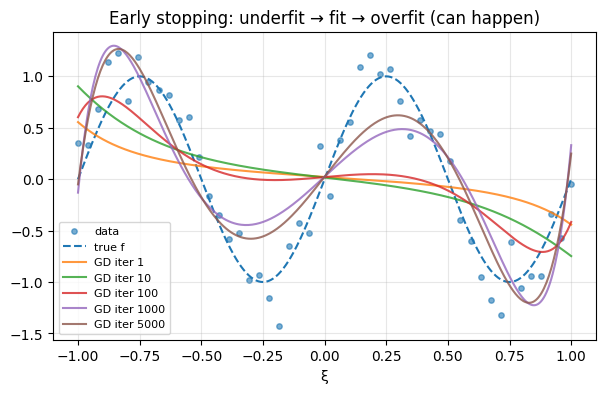

alpha used: 1.576e-02 (1/λ_max)


In [14]:
# Early stopping experiment: gradient descent on least squares

w0 = np.zeros(degree)

alpha = 1.0 / evals[-1]   # conservative (<= 1/L)
steps = 5000

traj_w = run_gd(A, b, w0, alpha, steps)

# Evaluate fits at a few iterations
iters = [1, 10, 100, 1000, 5000]
plt.figure(figsize=(7, 4))
plt.scatter(xi, d, s=15, alpha=0.6, label="data")
plt.plot(xi_plot, true_f(xi_plot), linestyle="--", label="true f")

for k in iters:
    wk = traj_w[k]
    fit = Z_plot @ wk
    plt.plot(xi_plot, fit, label=f"GD iter {k}", alpha=0.8)

plt.title("Early stopping: underfit → fit → overfit (can happen)")
plt.xlabel("ξ")
plt.grid(alpha=0.3)
plt.legend(fontsize=8)
plt.show()

print(f"alpha used: {alpha:.3e} (1/λ_max)")


## 2.5 Quick self-test (Polynomial Regression)

*Without scrolling up:*

1. For least squares $\min_w \|Zw - d\|^2$, what is the Hessian $A$ in quadratic form?
2. How are the eigenvalues of $Z^\top Z$ related to the singular values of $Z$?
3. Why does early stopping act like regularization?
4. What is the "spectral filter" for GD after $k$ steps?

<details>
<summary>Answers</summary>

1. $A = Z^\top Z$
2. If $Z = U\Sigma V^\top$, then eigenvalues of $Z^\top Z$ are $\sigma_i^2$.
3. Early stopping suppresses small-eigenvalue directions, similar to how ridge regression does.
4. $g_k(\lambda) = 1 - (1-\alpha\lambda)^k$ — this starts at 0 and approaches 1, suppressing small $\lambda$ early.

</details>

# 3. The Dynamics of Momentum

Momentum is not "mystical." On quadratics it is a **2nd‑order linear system** per eigenmode.  
That means: eigenvalues of a 2×2 matrix tell you everything (rates, oscillations, stability).

## 3.1 Add-on: From the update rule to a scalar 2nd‑order recurrence

Momentum (heavy-ball):

$$
z_{k+1}=\beta z_k + \nabla f(w_k),\qquad
w_{k+1}=w_k-\alpha z_{k+1}.
$$

On the quadratic, $\nabla f(w_k)=A(w_k-w^\star)=Ae_k$.

In eigenmode $i$, define scalar error $x_k := x^{(i)}_k$. Then:

$$
\begin{aligned}
y_{k+1} &= \beta y_k + \lambda x_k \\
x_{k+1} &= x_k - \alpha y_{k+1}
\end{aligned}
$$

Eliminate $y$. From $x_{k}=x_{k-1}-\alpha y_{k}$ we get $y_k=(x_{k-1}-x_k)/\alpha$. Substitute into the first:

$$
\frac{x_k-x_{k+1}}{\alpha} = \beta\frac{x_{k-1}-x_k}{\alpha} + \lambda x_k
$$

Multiply by $\alpha$ and rearrange:

$$
x_{k+1} = (1+\beta-\alpha\lambda)\,x_k - \beta x_{k-1}.
$$

That is a classic discrete-time 2nd-order system. Oscillations happen when the characteristic roots are complex.

## 3.2 Add-on: 2×2 matrix form and characteristic polynomial

Write the single-mode state as $[y_k,\;x_k]^\top$. Then:

$$
\begin{bmatrix} y_{k+1} \\ x_{k+1}\end{bmatrix}
=
\underbrace{\begin{bmatrix}
\beta & \lambda \\
-\alpha\beta & 1-\alpha\lambda
\end{bmatrix}}_{R(\alpha,\beta,\lambda)}
\begin{bmatrix} y_{k} \\ x_{k}\end{bmatrix}.
$$

Convergence in mode $\lambda$ is governed by the spectral radius $\rho(R)$.

The characteristic polynomial:

$$
\det(R-\sigma I)=0
\;\Rightarrow\;
\sigma^2 - (1+\beta-\alpha\lambda)\sigma + \beta = 0.
$$

Roots:

$$
\sigma_{1,2}=\frac{(1+\beta-\alpha\lambda)\pm\sqrt{(1+\beta-\alpha\lambda)^2-4\beta}}{2}.
$$

- **Complex roots** when $(1+\beta-\alpha\lambda)^2<4\beta$ → oscillatory "ringing"
- **Real roots** otherwise → overdamped / unstable depending on magnitude

## 3.3 Add-on: Stability region $0<\alpha\lambda<2+2\beta$ (derive, don't memorize)

We want both characteristic roots inside the unit circle: $|\sigma_{1,2}|<1$.

For a 2nd-order polynomial
$$
\sigma^2 + p\sigma + q = 0
$$
a standard discrete-time stability test (Jury) says the roots satisfy $|\sigma|<1$ iff:

1) $|q|<1$
2) $1+p+q>0$
3) $1-p+q>0$

Our polynomial is:

$$
\sigma^2 - a\sigma + \beta = 0
\quad\text{with}\quad
a := 1+\beta-\alpha\lambda.
$$

So $p=-a$, $q=\beta$. Assume $0\le \beta <1$. Then:

1) $|q|<1 \Rightarrow \beta<1$ ✅
2) $1+p+q>0 \Rightarrow 1-a+\beta>0$

$$
1-(1+\beta-\alpha\lambda)+\beta = \alpha\lambda > 0
$$

3) $1-p+q>0 \Rightarrow 1+a+\beta>0$

$$
1+(1+\beta-\alpha\lambda)+\beta = 2+2\beta-\alpha\lambda > 0
\Rightarrow \alpha\lambda < 2+2\beta
$$

So, for $0\le\beta<1$:

$$
\boxed{0 < \alpha\lambda < 2+2\beta}
$$

This cleanly recovers GD when $\beta=0$: $0<\alpha\lambda<2$.

## 3.4 Prediction (momentum convergence factor heatmap)

**Before running:**

1. For $\beta=0$ (GD), the stable region is $\alpha\lambda < 2$. With momentum, should it be larger or smaller?
2. Where on the $(\alpha, \beta)$ plane is the convergence factor minimized — high $\beta$ or low $\beta$?
3. The critical damping curve $\beta = (1-\sqrt{\alpha\lambda})^2$ — does it pass through the region of fastest convergence?

---

**After running, check:** Can you identify the "sweet spot" visually? Is it on the critical damping curve?

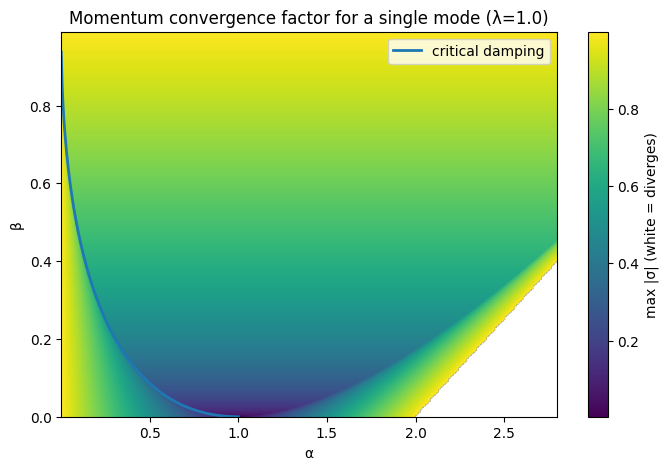

In [15]:
# Experiment: convergence factor over (α, β) for one eigenvalue λ

def momentum_mode_rate(alpha: float, beta: float, lam: float) -> float:
    """Compute the per-iteration convergence factor for momentum on a single eigenmode.
    
    For the 2nd-order recurrence x_{k+1} = (1+β-αλ)x_k - βx_{k-1}, this returns
    the spectral radius of the iteration matrix, i.e., max|σ| where σ are the
    roots of the characteristic polynomial σ² - (1+β-αλ)σ + β = 0.
    
    Returns:
        Convergence factor ρ ∈ [0, ∞). Values < 1 indicate convergence.
        For complex roots (underdamped), ρ = √β.
        For real roots, ρ = max(|σ₁|, |σ₂|).
    """
    a = 1 + beta - alpha * lam
    disc = a*a - 4*beta
    if disc >= 0:
        s1 = (a + np.sqrt(disc)) / 2
        s2 = (a - np.sqrt(disc)) / 2
        return max(abs(s1), abs(s2))
    else:
        # complex conjugates with product beta -> |σ| = sqrt(beta)
        return np.sqrt(beta)

lam = 1.0
alpha_vals = np.linspace(0.001, 2.8, 300)
beta_vals = np.linspace(0.0, 0.99, 250)

rates = np.zeros((len(beta_vals), len(alpha_vals)))
for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):
        rates[i, j] = momentum_mode_rate(alpha, beta, lam)

# mask unstable
rates_masked = rates.copy()
rates_masked[rates_masked >= 1] = np.nan

plt.figure(figsize=(8, 5))
plt.imshow(
    rates_masked,
    extent=[alpha_vals[0], alpha_vals[-1], beta_vals[0], beta_vals[-1]],
    origin="lower",
    aspect="auto",
)
plt.colorbar(label="max |σ| (white = diverges)")
plt.title(f"Momentum convergence factor for a single mode (λ={lam})")
plt.xlabel("α")
plt.ylabel("β")

# Critical damping curve: β = (1 - sqrt(αλ))^2 for αλ in [0,1]
alpha_crit = np.linspace(0.001, 1/lam, 200)
beta_crit = (1 - np.sqrt(alpha_crit * lam))**2
plt.plot(alpha_crit, beta_crit, linewidth=2, label="critical damping")

plt.legend()
plt.show()

## 3.5 Quick self-test (The Dynamics of Momentum)

*Without scrolling up:*

1. Write the 2nd-order recurrence for momentum in one eigenmode: $x_{k+1} = (?)x_k - (?)x_{k-1}$.
2. What is the characteristic polynomial?
3. When are the roots complex (oscillatory regime)?
4. What is the stability condition for momentum in terms of $\alpha\lambda$ and $\beta$?

<details>
<summary>Answers</summary>

1. $x_{k+1} = (1 + \beta - \alpha\lambda)x_k - \beta x_{k-1}$
2. $\sigma^2 - (1+\beta-\alpha\lambda)\sigma + \beta = 0$
3. When discriminant $< 0$: $(1+\beta-\alpha\lambda)^2 < 4\beta$
4. $0 < \alpha\lambda < 2 + 2\beta$ (for $0 \le \beta < 1$)

</details>

## 3.6 The Critical Damping Coefficient

The article frames a single eigenmode as a damped spring.  
Critical damping = fastest return to equilibrium without oscillation.

### 3.6.1 Add-on: Critical damping via discriminant $=0$

For one mode $\lambda$, characteristic polynomial is:

$$
\sigma^2 - (1+\beta-\alpha\lambda)\sigma + \beta = 0.
$$

Critical damping means **repeated root**, i.e. discriminant $=0$:

$$
(1+\beta-\alpha\lambda)^2 - 4\beta = 0.
$$

Let $u=\sqrt{\beta}$ (so $\beta=u^2$, $u\ge 0$):

$$
(1+u^2-\alpha\lambda)^2 = (2u)^2.
$$

Take the physically relevant branch $u\le 1$:

$$
1+u^2-\alpha\lambda = 2u
\;\Rightarrow\;
(1-u)^2 = \alpha\lambda
\;\Rightarrow\;
u = 1-\sqrt{\alpha\lambda}.
$$

So

$$
\boxed{\beta^\star = (1-\sqrt{\alpha\lambda})^2}
$$

and the repeated root is $\sigma = u = 1-\sqrt{\alpha\lambda}$.  
That gives the per-mode convergence factor:

$$
|x_k| \approx (1-\sqrt{\alpha\lambda})^k |x_0|.
$$

Compare GD's factor $1-\alpha\lambda$: the square root is the whole "acceleration" story.

### 3.6.2 Add-on: (Optional) "damped spring" mapping in one paragraph

For a quadratic $f(x)=\tfrac{1}{2}\lambda x^2$, the continuous-time damped oscillator is:

$$
\ddot x(t) + c\,\dot x(t) + \lambda x(t)=0.
$$

Momentum behaves like a simple discrete-time simulation of this ODE when $\alpha$ is small and $\beta$ is close to 1:
- the "spring force" is $\lambda x$
- $\beta$ controls damping (how much velocity is retained)
- critical damping is the boundary between oscillation and monotone return

You don't need the ODE to do the discrete math — but the picture helps you predict ringing.

### 3.6.3 Prediction (phase portraits: under/critical/overdamped)

**Before running:**

1. **Underdamped** ($\beta=0.95$, high): should the trajectory spiral inward or go straight?
2. **Critical** ($\beta = (1-\sqrt{\alpha\lambda})^2$): spiral or straight approach?
3. **Overdamped** ($\beta=0.2$, low): spiral or straight?
4. Which damping regime reaches the origin fastest?

---

**After running, check:** Match each phase portrait to your prediction. Which had oscillations?

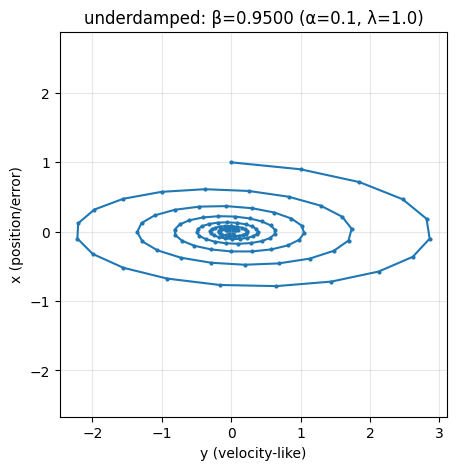

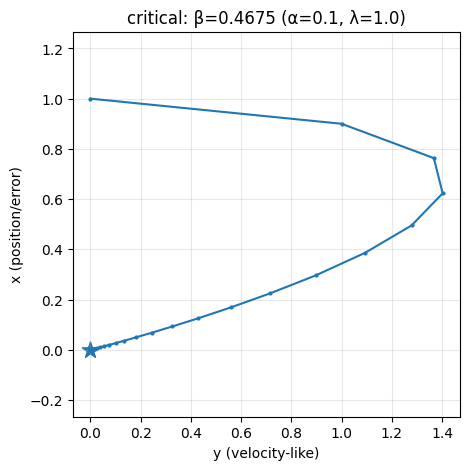

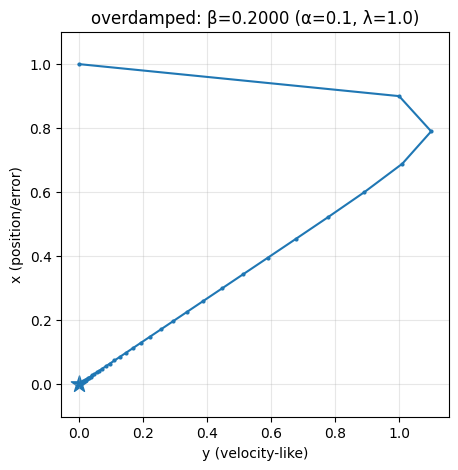

In [16]:
# Experiment: phase portrait for one mode (y vs x) in under/critical/over damping

def run_mode(alpha: float, beta: float, lam: float, 
             x0: float = 1.0, y0: float = 0.0, steps: int = 80) -> np.ndarray:
    """Simulate one eigenmode of momentum dynamics and return the phase trajectory.
    
    State variables:
        y: "velocity-like" — the momentum buffer (accumulated gradient)
        x: "position" — the error in this eigenmode (distance from optimum)
    
    Update equations:
        y_{k+1} = β y_k + λ x_k
        x_{k+1} = x_k - α y_{k+1}
    
    Returns:
        Array of shape (steps+1, 2) where each row is (y, x).
    """
    x, y = float(x0), float(y0)
    traj = [(y, x)]
    for _ in range(steps):
        y_new = beta * y + lam * x
        x_new = x - alpha * y_new
        x, y = x_new, y_new
        traj.append((y, x))
    return np.array(traj)

lam = 1.0
alpha = 0.1
beta_crit = (1 - np.sqrt(alpha * lam))**2

cases = [
    ("underdamped", 0.95),
    ("critical", beta_crit),
    ("overdamped", 0.2),
]

for name, beta in cases:
    traj = run_mode(alpha, beta, lam, steps=120)
    plt.figure(figsize=(5, 5))
    plt.plot(traj[:, 0], traj[:, 1], marker='o', markersize=2)
    plt.scatter([0.0], [0.0], marker='*', s=150)
    plt.title(f"{name}: β={beta:.4f} (α={alpha}, λ={lam})")
    plt.xlabel("y (velocity-like)")
    plt.ylabel("x (position/error)")
    plt.grid(alpha=0.3)
    plt.axis("equal")
    plt.show()

## 3.7 Optimal parameters

Critical damping is a *per-eigenvalue* sweet spot.  
But real problems have a range $\lambda \in [\lambda_1,\lambda_n]$. So the real question is: how do we pick one $\alpha,\beta$ that works well for *all* modes?

### 3.7.1 Add-on: The optimal heavy-ball parameters on $[\lambda_1,\lambda_n]$

For strongly convex quadratics with spectrum in $[\lambda_1,\lambda_n]$, the classical optimal heavy-ball choice is:

$$
\boxed{
\alpha^\star=\left(\frac{2}{\sqrt{\lambda_1}+\sqrt{\lambda_n}}\right)^2,\qquad
\beta^\star=\left(\frac{\sqrt{\lambda_n}-\sqrt{\lambda_1}}{\sqrt{\lambda_n}+\sqrt{\lambda_1}}\right)^2
}
$$

and the worst-case per-iteration contraction factor becomes:

$$
\boxed{
\rho_\text{mom} = \frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}
}
\qquad(\kappa=\lambda_n/\lambda_1).
$$

Compare GD's best factor:

$$
\rho_\text{gd} = \frac{\kappa-1}{\kappa+1}.
$$

Asymptotically:
- $1-\rho_\text{gd} = \Theta(1/\kappa)$
- $1-\rho_\text{mom} = \Theta(1/\sqrt{\kappa})$

That's the "square-rooting the condition number" slogan, made literal.

### 3.7.2 Prediction (GD vs momentum comparison)

**Before running:**

1. For $\kappa=100$: $\rho_\text{GD} = (\kappa-1)/(\kappa+1) \approx ?$ and $\rho_\text{mom} = (\sqrt{\kappa}-1)/(\sqrt{\kappa}+1) \approx ?$
2. How many iterations does GD need for $10^{-6}$ reduction? Momentum?
3. What's the approximate speedup factor?

---

**After running, check:** Did your mental arithmetic match the computed values?

### 3.7.3 Add-on: Why $\sqrt{\kappa}$ shows up (polynomial / Chebyshev viewpoint)

After $k$ steps, many first-order methods produce an iterate whose error in each eigenmode $\lambda$ looks like:

$$
x_k(\lambda)=p_k(\lambda)\,x_0(\lambda)
$$

for some degree-$k$ polynomial $p_k$ with $p_k(0)=1$.

So the "best method" in a class becomes:

$$
\min_{p_k} \max_{\lambda\in[\lambda_1,\lambda_n]} |p_k(\lambda)|.
$$

The minimax solution is governed by **Chebyshev polynomials**, and that optimization produces the $\sqrt{\kappa}$ rate.

You don't need to memorize Chebyshev details — just remember:  
**acceleration = choosing a smarter polynomial filter over the spectrum.**

### 3.7.4 Add-on: The Chebyshev connection (why $\sqrt{\kappa}$ is inevitable)

This is the deepest "why" for the $\sqrt{\kappa}$ improvement. Let's make it concrete.

#### The residual polynomial perspective

After $k$ steps of any first-order method, the error in eigenmode $\lambda$ has the form:

$$
x_k(\lambda) = p_k(\lambda) \cdot x_0(\lambda)
$$

where $p_k$ is a degree-$k$ polynomial satisfying $p_k(0) = 1$ (because at $\lambda=0$ there's no curvature, so error doesn't shrink).

**For GD:**
$$p_k^{\text{GD}}(\lambda) = (1 - \alpha\lambda)^k$$

**For momentum:** It can be shown that the optimal choice gives a polynomial related to **Chebyshev polynomials**.

#### Chebyshev polynomials $T_k$

The Chebyshev polynomial $T_k(x)$ is defined on $[-1, 1]$ by:
$$T_k(\cos\theta) = \cos(k\theta)$$

**Key property (Chebyshev's theorem):** Among all monic polynomials of degree $k$, the one with smallest max-norm on $[-1, 1]$ is $T_k(x)/2^{k-1}$, with max value $1/2^{k-1}$.

#### Why this gives $\sqrt{\kappa}$

We want to minimize $\max_{\lambda \in [\lambda_1, \lambda_n]} |p_k(\lambda)|$ subject to $p_k(0) = 1$.

**Linear transformation:** Map $[\lambda_1, \lambda_n]$ to $[-1, 1]$:
$$\lambda \mapsto t(\lambda) = \frac{2\lambda - (\lambda_1 + \lambda_n)}{\lambda_n - \lambda_1}$$

Then $\lambda = 0$ maps to:
$$t(0) = \frac{-(\lambda_1 + \lambda_n)}{\lambda_n - \lambda_1} = -\frac{\kappa + 1}{\kappa - 1}$$

The optimal residual polynomial is:
$$p_k(\lambda) = \frac{T_k(t(\lambda))}{T_k(t(0))}$$

This satisfies $p_k(0) = 1$ and minimizes the max-norm on $[\lambda_1, \lambda_n]$.

**The rate:** Using Chebyshev asymptotics, for large $|t(0)|$:
$$T_k(t(0)) \approx \frac{1}{2}\left(t(0) + \sqrt{t(0)^2 - 1}\right)^k$$

After simplification (the algebra is in standard references), this yields:
$$\max_{\lambda \in [\lambda_1, \lambda_n]} |p_k(\lambda)| \approx 2 \left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}\right)^k$$

**The $\sqrt{\kappa}$ emerges from the location of $t(0)$ relative to $[-1, 1]$.**

#### Connection to momentum

Heavy-ball momentum with optimal parameters produces iterates whose residual polynomial approximates the optimal Chebyshev-based polynomial.

This is why:
- Momentum's rate is $(\sqrt{\kappa}-1)/(\sqrt{\kappa}+1)$
- You can't do better with any polynomial of the same degree
- The $\sqrt{\kappa}$ improvement over GD is fundamental, not a trick

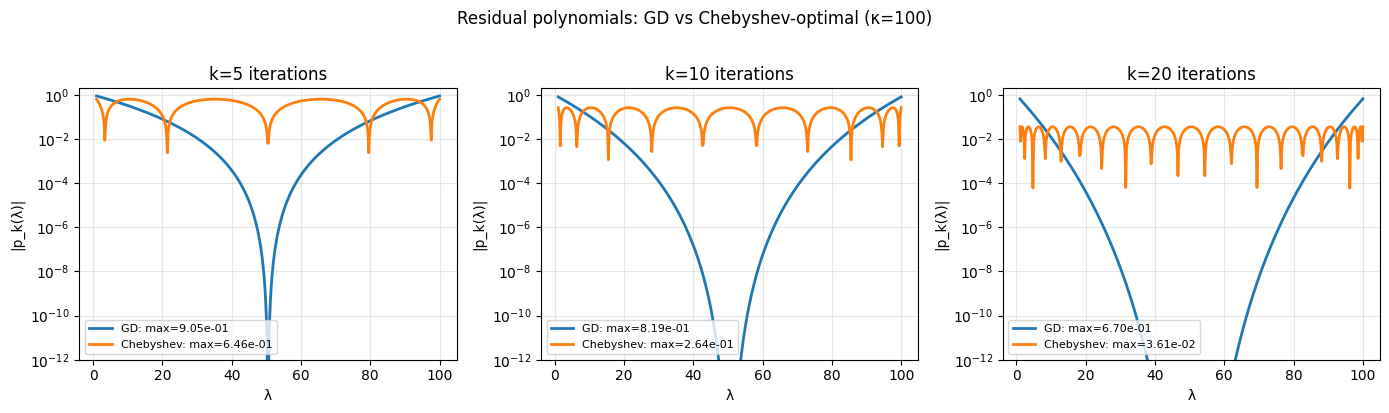

κ = 100
GD rate:        ρ_GD = 0.980198
Chebyshev rate: ρ_Cheb = 0.818182
Speedup factor: 0.1x fewer iterations


In [17]:
# Experiment: visualize residual polynomials and the Chebyshev advantage

def chebyshev_T(k, x):
    """Chebyshev polynomial of the first kind, T_k(x)."""
    # Use the recurrence: T_0=1, T_1=x, T_{k+1} = 2x T_k - T_{k-1}
    if k == 0:
        return np.ones_like(x)
    elif k == 1:
        return x.copy()
    T_prev, T_curr = np.ones_like(x), x.copy()
    for _ in range(k - 1):
        T_next = 2 * x * T_curr - T_prev
        T_prev, T_curr = T_curr, T_next
    return T_curr

def optimal_residual_polynomial(k, lam, lambda1, lambda_n):
    """Optimal residual polynomial p_k(λ) based on Chebyshev."""
    # Map [λ1, λn] to [-1, 1]
    t = (2 * lam - (lambda1 + lambda_n)) / (lambda_n - lambda1)
    t0 = -(lambda1 + lambda_n) / (lambda_n - lambda1)
    return chebyshev_T(k, t) / chebyshev_T(k, np.array([t0]))[0]

def gd_residual_polynomial(k, lam, alpha):
    """GD residual polynomial: (1 - αλ)^k"""
    return (1 - alpha * lam) ** k

# Setup
lambda1, lambda_n = 1.0, 100.0
kappa = lambda_n / lambda1
alpha_gd_opt = 2 / (lambda1 + lambda_n)

lam_vals = np.linspace(lambda1, lambda_n, 500)
k_vals = [5, 10, 20]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, k in zip(axes, k_vals):
    # GD residual polynomial
    p_gd = gd_residual_polynomial(k, lam_vals, alpha_gd_opt)
    
    # Optimal (Chebyshev-based) residual polynomial
    p_opt = optimal_residual_polynomial(k, lam_vals, lambda1, lambda_n)
    
    ax.plot(lam_vals, np.abs(p_gd), label=f"GD: max={np.max(np.abs(p_gd)):.2e}", linewidth=2)
    ax.plot(lam_vals, np.abs(p_opt), label=f"Chebyshev: max={np.max(np.abs(p_opt)):.2e}", linewidth=2)
    ax.set_xlabel("λ")
    ax.set_ylabel("|p_k(λ)|")
    ax.set_title(f"k={k} iterations")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_yscale('log')
    ax.set_ylim(1e-12, 2)

plt.suptitle(f"Residual polynomials: GD vs Chebyshev-optimal (κ={kappa:.0f})", y=1.02)
plt.tight_layout()
plt.show()

# Show the rates
rho_gd = (kappa - 1) / (kappa + 1)
rho_cheb = (np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1)
print(f"κ = {kappa:.0f}")
print(f"GD rate:        ρ_GD = {rho_gd:.6f}")
print(f"Chebyshev rate: ρ_Cheb = {rho_cheb:.6f}")
print(f"Speedup factor: {np.log(rho_gd) / np.log(rho_cheb):.1f}x fewer iterations")

### 3.7.5 Prediction (2D quadratic trajectory comparison)

**Before running:**

1. With $\kappa=25$, should momentum show visible speedup or only marginal improvement?
2. Will the momentum trajectory oscillate or go more directly to $w^*$?
3. On a log-scale loss plot, should momentum's slope be steeper or shallower than GD's?

---

**After running, check:** Count iterations until each method's loss drops below $10^{-4}$.

In [18]:
# Experiment: compare optimal GD vs optimal momentum rates as κ grows

def optimal_gd(lambda1, lambda_n):
    alpha = 2 / (lambda1 + lambda_n)
    rho = (lambda_n - lambda1) / (lambda_n + lambda1)
    return alpha, rho

def optimal_momentum(lambda1, lambda_n):
    s1, sn = np.sqrt(lambda1), np.sqrt(lambda_n)
    alpha = (2 / (s1 + sn))**2
    beta = ((sn - s1) / (sn + s1))**2
    rho = (sn - s1) / (sn + s1)
    return alpha, beta, rho

kappas = [10, 100, 1000, 10000]
lambda1 = 1.0

print(f"{'κ':>8} | {'rho_gd':>10} | {'rho_mom':>10} | {'iters_gd':>10} | {'iters_mom':>10} | {'speedup':>8}")
print("-"*70)
for kappa in kappas:
    lambda_n = kappa * lambda1
    _, rho_gd = optimal_gd(lambda1, lambda_n)
    _, _, rho_mom = optimal_momentum(lambda1, lambda_n)
    it_gd = np.log(1e-6) / np.log(rho_gd)
    it_mom = np.log(1e-6) / np.log(rho_mom)
    print(f"{kappa:8d} | {rho_gd:10.6f} | {rho_mom:10.6f} | {it_gd:10.0f} | {it_mom:10.0f} | {it_gd/it_mom:8.1f}x")


       κ |     rho_gd |    rho_mom |   iters_gd |  iters_mom |  speedup
----------------------------------------------------------------------
      10 |   0.818182 |   0.519494 |         69 |         21 |      3.3x
     100 |   0.980198 |   0.818182 |        691 |         69 |     10.0x
    1000 |   0.998002 |   0.938693 |       6908 |        218 |     31.6x
   10000 |   0.999800 |   0.980198 |      69078 |        691 |    100.0x


In [19]:
# Experiment: GD vs momentum on a 2D quadratic

lambda1, lambda2 = 0.2, 5.0   # κ = 25
A, Q = make_spd_quadratic([lambda1, lambda2], theta=np.pi/5)
b = np.array([1.0, 1.0])
w_star = quad_optimum(A, b)

w0 = np.array([-1.0, -1.0])
steps = 80

alpha_gd, _ = optimal_gd(lambda1, lambda2)
alpha_m, beta_m, _ = optimal_momentum(lambda1, lambda2)

traj_gd = run_gd(A, b, w0, alpha_gd, steps)
traj_m = run_momentum(A, b, w0, alpha_m, beta_m, steps)

f_star = quad_loss(w_star, A, b)
loss_gd = np.array([quad_loss(w, A, b) - f_star for w in traj_gd])
loss_m = np.array([quad_loss(w, A, b) - f_star for w in traj_m])

print(f"GD: alpha={alpha_gd:.4f}")
print(f"Momentum: alpha={alpha_m:.4f}, beta={beta_m:.4f}")


GD: alpha=0.3846
Momentum: alpha=0.5556, beta=0.4444


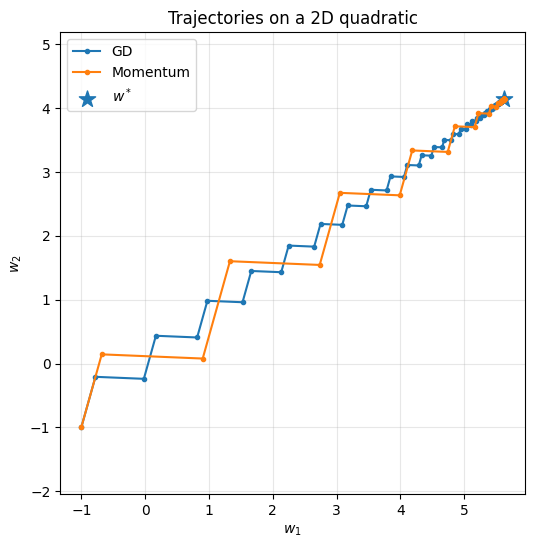

In [20]:
# Plot trajectory (original space)

plt.figure(figsize=(6, 6))
plt.plot(traj_gd[:, 0], traj_gd[:, 1], marker='o', markersize=3, label="GD")
plt.plot(traj_m[:, 0], traj_m[:, 1], marker='o', markersize=3, label="Momentum")
plt.scatter([w_star[0]], [w_star[1]], marker='*', s=150, label="$w^*$")
plt.title("Trajectories on a 2D quadratic")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.grid(alpha=0.3)
plt.legend()
plt.axis("equal")
plt.show()


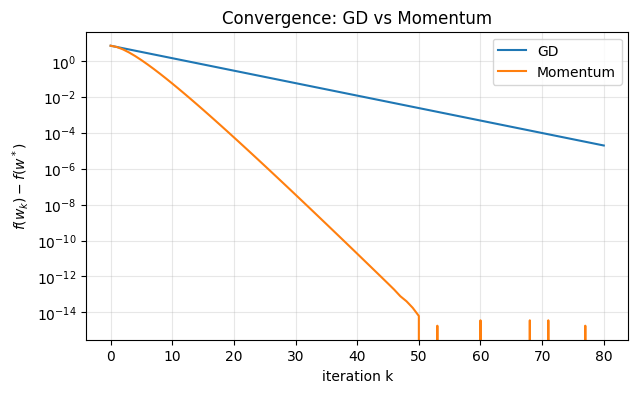

In [21]:
# Plot loss curves (log scale)

plt.figure(figsize=(7, 4))
plt.semilogy(loss_gd, label="GD")
plt.semilogy(loss_m, label="Momentum")
plt.title("Convergence: GD vs Momentum")
plt.xlabel("iteration k")
plt.ylabel(r"$f(w_k)-f(w^*)$")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


### 3.7.6 Quick self-test (Critical Damping and Optimal Parameters)

*Without scrolling up:*

1. What is critical damping in terms of discriminant?
2. Derive $\beta^* = (1 - \sqrt{\alpha\lambda})^2$ for one mode.
3. For spectrum $[\lambda_1, \lambda_n]$, what are optimal $\alpha^*$ and $\beta^*$?
4. What is the optimal momentum rate $\rho_\text{mom}$ in terms of $\kappa$?
5. How does this compare to GD's rate asymptotically?

<details>
<summary>Answers</summary>

1. Discriminant $= 0$ (repeated root)
2. Set $(1+\beta-\alpha\lambda)^2 = 4\beta$. Let $u=\sqrt{\beta}$, get $(1-u)^2 = \alpha\lambda$, so $u = 1-\sqrt{\alpha\lambda}$.
3. $\alpha^* = (2/(\sqrt{\lambda_1}+\sqrt{\lambda_n}))^2$, $\beta^* = ((\sqrt{\lambda_n}-\sqrt{\lambda_1})/(\sqrt{\lambda_n}+\sqrt{\lambda_1}))^2$
4. $\rho_\text{mom} = (\sqrt{\kappa}-1)/(\sqrt{\kappa}+1)$
5. GD: $1 - \rho \sim 1/\kappa$. Momentum: $1 - \rho \sim 1/\sqrt{\kappa}$. Momentum is $O(\sqrt{\kappa})$ faster.

</details>

# 4. Example: The Colorization Problem

The article reframes the optimization as "information diffusion on a graph."

Key takeaways:
- GD updates are **local averaging**
- Global structure emerges only through repeated local steps (diffusion is slow)
- Graph connectivity ↔ spectrum of Laplacian ↔ condition number ↔ optimization speed

## 4.1 Add-on: Graph Laplacian basics (PSD, zero eigenvalue, why $\lambda_2$ matters)

For an undirected graph $G=(V,E)$, the (combinatorial) Laplacian is:

$$
L = D - A_G
$$

where $D$ is the degree matrix and $A_G$ is adjacency.

Facts:

- $L$ is symmetric and **positive semidefinite**:
  $$
  x^\top L x = \sum_{(i,j)\in E} (x_i-x_j)^2 \ge 0.
  $$
- The all-ones vector is always an eigenvector with eigenvalue $0$: $L\mathbf{1}=0$.
- $\lambda_2$ (second-smallest eigenvalue) is the **algebraic connectivity** (Fiedler value):
  - small $\lambda_2$ → graph has bottlenecks → diffusion is slow
  - larger $\lambda_2$ → well-connected → diffusion is fast

In these Laplacian-dominated objectives, the "effective condition number" often looks like $\lambda_n/\lambda_2$ (since $\lambda_1=0$ is trivial).

## 4.2 Add-on: Conditioning as connectivity (diffusion intuition made explicit)

If the update is local averaging, then information spreads like diffusion:
- each step mixes each node with its neighbors
- long-range agreement takes many steps unless the graph has shortcuts

Spectrally:
- "slow modes" correspond to small eigenvalues (low-frequency graph signals)
- GD kills high-frequency errors quickly, but low-frequency errors linger
- momentum accelerates the slow modes (that's the whole point)

## 4.3 Prediction (graph Laplacian spectra)

**Before running:**

1. For a path graph of $n$ nodes, the condition number $\lambda_n/\lambda_2$ should scale like $O(?)$ in $n$.
2. For a grid graph ($m \times m$), how does the condition number scale with $m$?
3. Which graph family is more ill-conditioned for the same number of nodes — path or grid?

---

**After running, check:** Compare the actual condition numbers. Does the path graph confirm the $O(n^2)$ scaling intuition?

In [ ]:
# Experiment: Laplacian spectra for different graph families

def path_laplacian(n):
    L = np.zeros((n, n))
    for i in range(n):
        if i > 0:
            L[i, i] += 1
            L[i, i-1] -= 1
        if i < n-1:
            L[i, i] += 1
            L[i, i+1] -= 1
    return L

def grid_laplacian(m):
    # m x m grid, n=m^2 nodes, 4-neighborhood
    n = m*m
    L = np.zeros((n, n))
    def idx(i, j): return i*m + j
    for i in range(m):
        for j in range(m):
            u = idx(i, j)
            for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                ni, nj = i+di, j+dj
                if 0 <= ni < m and 0 <= nj < m:
                    v = idx(ni, nj)
                    L[u, u] += 1
                    L[u, v] -= 1
    return L

def laplacian_condition(L):
    evals = np.linalg.eigvalsh(L)
    evals = np.sort(evals)
    # skip evals[0]=0; use λ2 and λn
    return evals[-1] / evals[1], evals

for n in [10, 30, 100]:
    Lp = path_laplacian(n)
    kappa_p, evals_p = laplacian_condition(Lp)
    print(f"Path n={n:3d}: λ2={evals_p[1]:.4e}, λn={evals_p[-1]:.4e},  λn/λ2={kappa_p:.2e}")

print()

for m in [4, 8, 12]:
    Lg = grid_laplacian(m)
    kappa_g, evals_g = laplacian_condition(Lg)
    print(f"Grid {m}x{m} (n={m*m:3d}): λ2={evals_g[1]:.4e}, λn={evals_g[-1]:.4e},  λn/λ2={kappa_g:.2e}")


## 4.4 Prediction (path graph colorization diffusion)

**Before running:**

1. With one pinned node at the left, how does the "color" spread along the chain?
2. At iteration $k$, roughly how far along the chain has information propagated?
3. Should momentum's snapshots show the color reaching the right side faster than GD?

---

**After running, check:** Does momentum visibly accelerate the diffusion? Compare the $k=20$ and $k=60$ snapshots.

In [ ]:
# Optional experiment: "colorization" diffusion on a path graph (one pinned node)

n = 60
L = path_laplacian(n)
e1 = np.zeros(n); e1[0] = 1.0

A = L + np.outer(e1, e1)   # pin node 1 to break the constant-mode nullspace
b = e1

# Spectrum for tuning
evals = np.linalg.eigvalsh(A)
lambda1, lambda_n = evals[0], evals[-1]
kappa = lambda_n / lambda1

alpha_gd, _ = optimal_gd(lambda1, lambda_n)
alpha_m, beta_m, _ = optimal_momentum(lambda1, lambda_n)

w0 = np.zeros(n)
steps = 200

traj_gd = run_gd(A, b, w0, alpha_gd, steps)
traj_m = run_momentum(A, b, w0, alpha_m, beta_m, steps)

# Plot snapshots of w along the chain
snapshots = [0, 5, 20, 60, 200]
x = np.arange(n)

plt.figure(figsize=(7, 4))
for k in snapshots:
    plt.plot(x, traj_gd[k], label=f"GD k={k}", alpha=0.8)
plt.title(f"Path graph: GD diffusion snapshots (n={n}, κ≈{kappa:.1e})")
plt.xlabel("node index")
plt.ylabel("w")
plt.grid(alpha=0.3)
plt.legend(fontsize=8)
plt.show()

plt.figure(figsize=(7, 4))
for k in snapshots:
    plt.plot(x, traj_m[k], label=f"Mom k={k}", alpha=0.8)
plt.title(f"Path graph: Momentum diffusion snapshots (n={n}, κ≈{kappa:.1e})")
plt.xlabel("node index")
plt.ylabel("w")
plt.grid(alpha=0.3)
plt.legend(fontsize=8)
plt.show()

print(f"A spectrum: λ_min={lambda1:.3e}, λ_max={lambda_n:.3e}, κ≈{kappa:.2e}")
print(f"GD alpha={alpha_gd:.3e}")
print(f"Momentum alpha={alpha_m:.3e}, beta={beta_m:.4f}")


## 4.5 Quick self-test (The Colorization Problem / Graph Laplacian)

*Without scrolling up:*

1. What is the graph Laplacian $L$ in terms of degree matrix $D$ and adjacency $A_G$?
2. Why is $L$ positive semidefinite?
3. What is the eigenvalue associated with the all-ones vector?
4. What does $\lambda_2$ (algebraic connectivity) tell you about the graph?
5. Why does diffusion on a path graph take $O(n^2)$ iterations?

<details>
<summary>Answers</summary>

1. $L = D - A_G$
2. $x^\top L x = \sum_{(i,j) \in E} (x_i - x_j)^2 \ge 0$
3. $\lambda_1 = 0$ (constant vector is in nullspace)
4. Small $\lambda_2$ means bottlenecks/poor connectivity; large $\lambda_2$ means well-connected.
5. Condition number $\lambda_n/\lambda_2 \sim O(n^2)$, so GD needs $O(\kappa) = O(n^2)$ iterations.

</details>

# 5. The Limits of Descent

After seeing a quadratic speedup, a natural question is: can we do even better with cleverer first-order tricks?

The article's answer: within a broad class of **linear first-order methods**, there's a lower bound — and momentum essentially meets it on a worst-case function.

## 5.1 Adventures in Algorithmic Space

The article "unrolls" algorithms to describe a broad search space of first-order methods.

### 5.1.1 Add-on: Unrolling GD and momentum (explicit gradient weights)

GD:

$$
w_{k+1}=w_k-\alpha \nabla f(w_k)
$$

Unroll:

$$
w_{k+1}=w_0 - \alpha\sum_{i=0}^k \nabla f(w_i).
$$

Momentum (heavy-ball) can also be unrolled to:

$$
w_{k+1}=w_0 - \alpha\sum_{i=0}^k \underbrace{\frac{1-\beta^{k+1-i}}{1-\beta}}_{\text{increasing weight for recent grads}} \nabla f(w_i)
$$

(up to the exact indexing convention — verify by induction in the exercise below).

This makes momentum look like GD with a particular **non-uniform weighting** of past gradients.

#### What "Linear First-Order Methods" means here

Roughly: algorithms whose iterates lie in the affine span of past gradients, with linear (often diagonal) coefficients.

It typically *includes*: GD, heavy-ball, Nesterov-style methods, conjugate gradient (on quadratics), etc.  
It typically *excludes*: full Newton, quasi-Newton with curvature updates, methods that query Hessian-vector products, etc.

In [ ]:
# Exercise check: verify the unrolled form of momentum on an arbitrary gradient sequence

np.random.seed(0)
k = 8
d = 5
alpha = 0.1
beta = 0.9

# Fake gradients g_0..g_k (not coming from any function)
g = [np.random.randn(d) for _ in range(k+1)]

# Momentum recursion
w = np.zeros(d)
z = np.zeros(d)
w_hist = [w.copy()]
for t in range(k+1):
    z = beta * z + g[t]
    w = w - alpha * z
    w_hist.append(w.copy())

w_direct = np.zeros(d)
for t in range(k+1):
    weight = (1 - beta**(k+1 - t)) / (1 - beta)
    w_direct = w_direct - alpha * weight * g[t]

print("Recursive w_{k+1}:", w_hist[-1])
print("Unrolled   w_{k+1}:", w_direct)
print("Difference norm:", np.linalg.norm(w_hist[-1] - w_direct))


## 5.2 The Resisting Oracle

The article constructs a worst-case "local interaction" objective (a path graph) where information can only propagate one step per iteration. This creates a **light cone**: coordinate $i$ cannot change before iteration $i$.

### 5.2.1 Add-on: Convex Rosenbrock (a "worst function") and the light cone proof

A simplified version (path graph + one anchored node + regularization) has the form:

$$
f(w)=\tfrac{1}{2}(w_1-1)^2 + \tfrac{1}{2}\sum_{i=1}^{n-1}(w_i-w_{i+1})^2 + \tfrac{2}{\kappa-1}\|w\|^2.
$$

Key structural fact:

- $\nabla f(w)_i$ depends only on $w_{i-1}, w_i, w_{i+1}$ (local coupling).

If you start at $w_0=0$, then by induction:
- at step 1, only coordinate 1 can move
- at step 2, only coordinates 1–2 can move
- …
- at step $k$, coordinates $>k$ are still exactly 0

That is the "light cone": information travels at speed 1 coordinate per iteration.

Lower bound idea:

If the true optimum has nonzero mass in coordinate $k+1$, then any linear first-order method must have nontrivial error at time $k$, because it physically cannot "reach" that coordinate yet.

### 5.2.2 Prediction (light cone visualization)

**Before running:**

1. Starting at $w_0 = 0$, which coordinate can change at iteration 1? At iteration $k$?
2. The plot shows $w_i^k$ as a heatmap. What shape should the "active" region form?
3. The boundary $i = k$ is the "light cone." Should any values appear above this line?

---

**After running, check:** Is the light cone boundary sharp? Why does this structure exist?

In [ ]:
# Experiment: visualize the light cone on Convex Rosenbrock (path-graph objective)

def convex_rosenbrock_grad(w, kappa):
    n = len(w)
    grad = np.zeros(n)

    # colorizer term: 0.5 (w1-1)^2
    grad[0] += (w[0] - 1.0)

    # smoother: 0.5 sum (w_i - w_{i+1})^2
    for i in range(n-1):
        diff = w[i] - w[i+1]
        grad[i]   += diff
        grad[i+1] -= diff

    # regularization: (2/(kappa-1)) ||w||^2  -> grad = (4/(kappa-1)) w
    grad += (4.0 / (kappa - 1.0)) * w
    return grad

def run_momentum_custom_grad(grad_fn, w0, alpha, beta, steps, **grad_kwargs):
    w = np.array(w0, dtype=float)
    z = np.zeros_like(w)
    hist = [w.copy()]
    for _ in range(steps):
        g = grad_fn(w, **grad_kwargs)
        z = beta * z + g
        w = w - alpha * z
        hist.append(w.copy())
    return np.asarray(hist)

n = 30
kappa = 100.0
w0 = np.zeros(n)

# Heuristic params: use alpha small and beta close to 1
alpha = 0.15
beta = 0.9
steps = 50

hist = run_momentum_custom_grad(convex_rosenbrock_grad, w0, alpha, beta, steps, kappa=kappa)

plt.figure(figsize=(8, 5))
plt.imshow(hist.T, aspect='auto', origin='lower')
plt.colorbar(label=r"$w_i^k$")
plt.title("Light cone: coordinate i cannot change before iteration i (structure-driven)")
plt.xlabel("iteration k")
plt.ylabel("coordinate i")
plt.plot(np.arange(steps+1), np.arange(steps+1), linestyle="--", linewidth=2, label="light cone boundary")
plt.legend()
plt.show()


### 5.2.3 Quick self-test (The Limits of Descent)

*Without scrolling up:*

1. What is the "light cone" constraint for linear first-order methods starting at $w_0 = 0$?
2. If the optimum has $w_i^* = r^i$ for some $r < 1$, what is the minimum error at iteration $k$?
3. What value of $r$ appears in the lower bound for the Convex Rosenbrock?
4. In what sense does momentum "match" this lower bound?

<details>
<summary>Answers</summary>

1. Coordinate $i$ cannot change before iteration $i$: $w_i^k = 0$ for $i > k$.
2. $\|w^k - w^*\|_\infty \ge |w^*_{k+1}| = r^{k+1}$
3. $r = (\sqrt{\kappa}-1)/(\sqrt{\kappa}+1)$
4. Momentum's convergence rate matches this $r$ (up to constants), so it's essentially optimal for this function class.

</details>

### 5.2.4 Add-on: The lower bound rate (how the "light cone" turns into $\left(\frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}\right)^k$)

The article states the optimum has the form:

$$
w_i^\star = \left(\frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}\right)^i.
$$

But for any linear first-order method started at 0, the light cone implies:

$$
w_i^k = 0\quad \text{for } i>k.
$$

So at time $k$, coordinate $k+1$ still has error:

$$
\|w^k-w^\star\|_\infty \ge |w^\star_{k+1}|
= \left(\frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}\right)^{k+1}.
$$

That gives a hard lower bound on achievable contraction per iteration in this algorithmic class — and momentum matches it (up to constants / asymptotics).

Spiritual interpretation: you can't beat physics if the objective only lets information move locally.

# 6. Momentum with Stochastic Gradients

Real ML rarely gives the true gradient. You get noisy estimates (minibatches).  
Momentum changes the *noise* dynamics too — not just the mean dynamics.

## 6.1 Add-on: A minimal noise model and the deterministic/stochastic split

Model minibatch gradient as:

$$
g(w_k) = \nabla f(w_k) + \epsilon_k,\quad \mathbb{E}[\epsilon_k]=0.
$$

Then momentum becomes a **linear system with additive noise**.

On a quadratic and in one eigenmode:

$$
\begin{aligned}
y_{k+1} &= \beta y_k + \lambda x_k + \epsilon_k \\
x_{k+1} &= x_k - \alpha y_{k+1}.
\end{aligned}
$$

Solution = (noiseless dynamics) + (filtered noise):

$$
\begin{bmatrix}y_k\\x_k\end{bmatrix}
= R^k\begin{bmatrix}y_0\\x_0\end{bmatrix}
+ \sum_{t=0}^{k-1} R^{k-1-t}\begin{bmatrix}1\\-\alpha\end{bmatrix}\epsilon_t.
$$

So noise is passed through a geometric filter $R^{\cdot}$. If $R$ is near the stability boundary, that filter has long memory.

## 6.2 Add-on: Why increasing $\beta$ can *increase* noise (despite "averaging")

If we ignore the signal for a moment and look at the momentum buffer under pure noise:

$$
y_{k+1} = \beta y_k + \epsilon_k,
\quad \epsilon_k \sim (0,\sigma^2).
$$

This is an AR(1) process with stationary variance:

$$
\mathrm{Var}(y)=\frac{\sigma^2}{1-\beta^2}.
$$

As $\beta\to 1$, the variance blows up like $\approx \sigma^2/(2(1-\beta))$.

So momentum *does* average, but it also **stores** noise for a long time when $\beta$ is close to 1.  
In late training, when gradients are small, this stored noise can dominate → higher variance "jitter" around the optimum.

That's the article's "two phases" story:
- **transient phase:** gradient signal ≫ noise → momentum helps
- **stochastic phase:** noise ≫ gradient signal → momentum can hurt

## 6.3 Prediction (stochastic gradient experiment)

**Before running:**

1. **Transient phase:** When the gradient signal is large, should momentum help or hurt?
2. **Late phase:** When near the optimum (small gradients), should high $\beta$ increase or decrease variance?
3. Will the mean loss curve for momentum eventually plateau *higher* or *lower* than SGD?
4. In the late-phase histogram, which method should have a wider spread?

---

**After running, check:** Do the two phases appear in the mean loss curves? Compare the late-phase distributions.

In [ ]:
# Experiment: stochastic gradients on a quadratic (SGD vs SGD+momentum)

def run_sgd_momentum(A, b, w0, alpha, beta, steps, noise_std, seed=None):
    rng = np.random.default_rng(seed)
    w = np.array(w0, dtype=float)
    z = np.zeros_like(w)
    traj = [w.copy()]
    for _ in range(steps):
        grad = A @ w - b
        grad_noisy = grad + noise_std * rng.standard_normal(size=w.shape)
        z = beta * z + grad_noisy
        w = w - alpha * z
        traj.append(w.copy())
    return np.asarray(traj)

# 2D quadratic
lambda1, lambda2 = 0.1, 10.0
A, Q = make_spd_quadratic([lambda1, lambda2], theta=np.pi/8)
b = np.array([1.0, 1.0])
w_star = quad_optimum(A, b)

evals = np.linalg.eigvalsh(A)
alpha_m, beta_m, _ = optimal_momentum(evals[0], evals[-1])

# Make step-size smaller to handle noise
alpha = 0.2 * alpha_m
noise_std = 0.5
steps = 250
trials = 40

def loss_centered(w):
    e = w - w_star
    return 0.5 * (e @ (A @ e))

losses_sgd = []
losses_mom = []

for t in range(trials):
    traj0 = run_sgd_momentum(A, b, np.zeros(2), alpha, 0.0, steps, noise_std, seed=t)
    trajm = run_sgd_momentum(A, b, np.zeros(2), alpha, 0.9, steps, noise_std, seed=10_000+t)
    losses_sgd.append([loss_centered(w) for w in traj0])
    losses_mom.append([loss_centered(w) for w in trajm])

losses_sgd = np.asarray(losses_sgd)
losses_mom = np.asarray(losses_mom)

mean_sgd = losses_sgd.mean(axis=0)
mean_mom = losses_mom.mean(axis=0)

plt.figure(figsize=(7, 4))
plt.semilogy(mean_sgd, label="SGD (β=0) mean")
plt.semilogy(mean_mom, label="SGD+Momentum (β=0.9) mean")
plt.title("Stochastic optimization: mean loss curves")
plt.xlabel("iteration k")
plt.ylabel(r"$\mathbb{E}[f(w_k)-f(w^*)]$")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Late-phase distribution
late = 50
plt.figure(figsize=(7, 4))
plt.hist(losses_sgd[:, -late:].reshape(-1), bins=30, alpha=0.6, label="SGD")
plt.hist(losses_mom[:, -late:].reshape(-1), bins=30, alpha=0.6, label="Momentum")
plt.title(f"Late-phase loss distribution (last {late} steps × {trials} trials)")
plt.xlabel("loss")
plt.ylabel("count")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

print(f"alpha used: {alpha:.3e}, noise_std: {noise_std}, trials: {trials}")


## 6.4 Quick self-test (Stochastic Gradients)

*Without scrolling up:*

1. Model the noisy gradient: $g(w_k) = \nabla f(w_k) + \epsilon_k$. How does momentum transform this noise?
2. For the AR(1) process $y_{k+1} = \beta y_k + \epsilon_k$, what is the stationary variance?
3. Why does high $\beta$ hurt in late training?
4. What are the "two phases" of stochastic optimization with momentum?

<details>
<summary>Answers</summary>

1. Noise is passed through a geometric filter $R^k$ where $R$ is the momentum iteration matrix.
2. $\text{Var}(y) = \sigma^2/(1-\beta^2)$
3. As $\beta \to 1$, variance $\approx \sigma^2/(2(1-\beta)) \to \infty$. Noise is stored for a long time.
4. **Transient phase:** gradient signal dominates noise, momentum helps. **Stochastic phase:** noise dominates, momentum can hurt by amplifying variance.

</details>

# 7. Onwards and Downwards

The article ends by pointing to other lenses on acceleration:
- differential equations
- polynomial approximation
- geometry
- duality

Below is a compact "what to remember" + a self-test you can do from memory.

## 7.1 Add-on: The 12-line compressed mental model

1. Near any point, smooth objectives look like a quadratic: curvature $A$ matters.
2. Symmetric $A$ diagonalizes → optimization decomposes into eigenmodes.
3. GD on mode $\lambda$: $x_{k+1}=(1-\alpha\lambda)x_k$.
4. Large $\lambda$ modes die quickly; small $\lambda$ modes linger → "plateau."
5. Best fixed GD step uses endpoints $\lambda_1,\lambda_n$: rate $(\kappa-1)/(\kappa+1)$.
6. Momentum introduces a second state → 2nd-order recurrence per mode.
7. That recurrence has roots $\sigma_{1,2}$; $|\sigma|$ controls speed, complex roots cause oscillations.
8. Critical damping makes roots repeated → fastest monotone return for one mode.
9. Globally tuned momentum makes worst-case rate $(\sqrt{\kappa}-1)/(\sqrt{\kappa}+1)$.
10. Graph/Laplacian problems: slow modes = global structure; momentum accelerates diffusion.
11. There's a lower bound for linear first-order methods; momentum essentially hits it on worst cases.
12. With noise, momentum can amplify variance late; it's a transient-phase weapon.

## 7.2 Add-on: Final self-test (close everything, do this on paper)

1) Starting from $w_{k+1}=w_k-\alpha(Aw_k-b)$, derive $e_{k+1}=(I-\alpha A)e_k$.

2) Show that in the eigenbasis, GD decouples: $x^{(i)}_{k+1}=(1-\alpha\lambda_i)x^{(i)}_k$.

3) For momentum, derive the 2nd-order recurrence:
$$
x_{k+1} = (1+\beta-\alpha\lambda)x_k - \beta x_{k-1}.
$$

4) From the characteristic polynomial, state the condition for oscillations (complex roots).

5) Derive the critical damping $\beta^\star=(1-\sqrt{\alpha\lambda})^2$.

6) State the optimal $\alpha^\star,\beta^\star$ for $[\lambda_1,\lambda_n]$ and the rate in terms of $\kappa$.

7) Explain the "light cone" lower bound in 2 sentences.

8) In the noise-only model $y_{k+1}=\beta y_k+\epsilon_k$, compute $\mathrm{Var}(y)$ at stationarity.

If you can do all 8 without looking, you own the core.

## 7.3 Acknowledgments

See the original article for full acknowledgments.

### 7.3.1 Discussion and Review

The Distill page links reviewer notes and discussion threads. Skim these after you've done the derivations — they often reveal where people get confused.

## 7.4 Footnotes

If you're going for "own it," the footnotes are not optional — they contain important caveats (e.g., momentum can diverge on carefully constructed convex examples).

## 7.5 References

A short "next stack" (also see the article's full reference list):

- Polyak (heavy-ball momentum)
- Nesterov (accelerated methods + lower bounds)
- Su, Boyd, Candès (ODE viewpoint of acceleration)
- O'Donoghue & Candès (adaptive restart for acceleration)
- Sutskever et al. (momentum in deep learning)

## 7.6 Updates and Corrections

Distill maintains a changelog for the article. If something here seems off, check whether the article was updated.

## 7.7 Citations and Reuse

The Distill page provides citation info and licensing details (CC-BY for text/diagrams unless otherwise noted).